# Sample Workflow for d3rlpy Experiments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import math
import subprocess
import os
import d3rlpy
plt.style.use('matplotlibrc')

from Python.data_sampler import *

## Building an MDPDataset

We first read in a large batch of samples from the file. As `d3rlpy` wants it in the form (observations, actions, rewards, terminal flags), we go ahead and do that. Here's a helper function to get a dataset from a list of chunks of your choosing.

In [2]:
def get_dataset(chunks : list, batch_size=30000, 
                path="collected_data/rl_deterministic.txt") -> d3rlpy.dataset.MDPDataset :
    random.seed(0)
    samples = DataSampler(path_to_data=path)
    states = []
    actions = []
    rewards = []
    next_states = []
    for chunk in chunks:
        samples.use_chunk(chunk)
        samples.read_chunk()
        [statesChunk, actionsChunk, rewardsChunk, nextStatesChunk] = samples.get_batch(batch_size)
        states.append(statesChunk)
        actions.append(actionsChunk)
        rewards.append(rewardsChunk)
        next_states.append(nextStatesChunk)
    states = torch.cat(states)
    actions = torch.cat(actions)
    rewards = torch.cat(rewards)
    next_states = torch.cat(next_states)
    terminals = np.zeros(len(states))
    terminals[::100] = 1 #episode length 100, change if necessary
    print(states.shape)
    dataset = d3rlpy.dataset.MDPDataset(states.numpy(), 
                                        actions.numpy(), 
                                        rewards.numpy(), terminals)
    return dataset, states.numpy(), actions.numpy(), rewards.numpy()

We can build the dataset from there, just like this, and split into train and test sets.

In [17]:
dataset, states, actions, rewards = get_dataset([i for i in range(11)], path="collected_data/rl_det_small.txt")

[ 0.00000000e+00  7.95731469e+08 -7.69891077e-02  4.00000469e-03
  5.99998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  1.50295370e-01 -2.41931634e-01  6.00000000e-01]
Read chunk # 1 out of 10000
[ 0.00000000e+00  7.95731469e+08  1.47410892e-01 -8.79999531e-03
  2.29998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  9.86362318e-02  3.75821673e-01 -6.00000000e-01]
Read chunk # 2 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.03891077e-02 -1.41999953e-02
 -2.10001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -1.78778459e-03 -1.34615461e-02  4.84073546e-02]
Read chunk # 3 out of 10000
[ 0.00000000e+00  7.95731469e+08 -8.17891077e-02 -1.19999531e-03
  7.39998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  2.09713430e-01 -2.63658359e-01  6.00000000e-01]
Read chunk # 4 out of 10000
[ 0.00000000e+00  7.95731469e+08 -7.24891077e-02 -1.35999953e-02
 -4.20001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -6.23311010e-02 -1.64283998e-01  6.00

In [18]:
print("The behavior policy value statistics are:")
dataset.compute_stats()['return']

The behavior policy value statistics are:


{'mean': -4.3529935,
 'std': 2.8112352,
 'min': -15.256291,
 'max': 0.0,
 'histogram': (array([ 38,  11,  13,  33,  23,  18,  22,  45,  98,  67,  88, 138, 209,
         293, 227, 536, 582, 376, 208,  30]),
  array([-15.256291 , -14.493477 , -13.730662 , -12.967848 , -12.205033 ,
         -11.442219 , -10.679404 ,  -9.91659  ,  -9.153775 ,  -8.390961 ,
          -7.6281457,  -6.865331 ,  -6.1025167,  -5.339702 ,  -4.5768876,
          -3.8140728,  -3.0512583,  -2.2884438,  -1.5256292,  -0.7628146,
           0.       ], dtype=float32))}

In [20]:
model.load_model('cqlDet100model.pt')

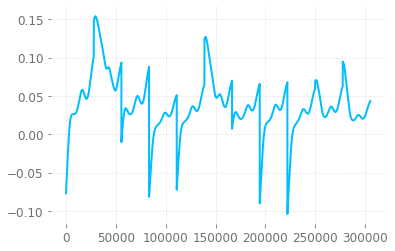

In [38]:
plt.plot(states[:,0])

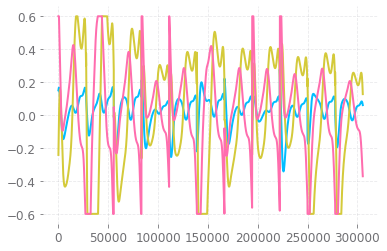

In [22]:
plt.plot(actions)

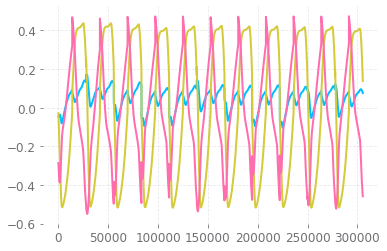

In [25]:
plt.plot(model.predict(states))

In [5]:
from sklearn.model_selection import train_test_split
train_episodes, test_episodes = train_test_split(dataset, test_size=0.2)

## Setting up an Algorithm

In [19]:
from d3rlpy.algos import CQL

from d3rlpy.preprocessing import MinMaxActionScaler
action_scaler = MinMaxActionScaler(minimum=-0.6, maximum=0.6)
#cql = CQL(action_scaler=action_scaler)

model = CQL(q_func_factory='mean', #qr -> quantile regression q function, but you don't have to use this
            reward_scaler='standard',
            action_scaler=action_scaler,
          actor_learning_rate=1e-5, 
          critic_learning_rate=0.0003, 
            use_gpu=False) #change it to true if you have one
model.build_with_dataset(dataset)

In [7]:
from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from d3rlpy.metrics.scorer import initial_state_value_estimation_scorer

# calculate metrics with test dataset
ave_error_init = average_value_estimation_scorer(model, test_episodes)
print(ave_error_init)

0.23601703744964858


In [9]:
%load_ext tensorboard
%tensorboard --logdir runs

In [10]:
model.fit(train_episodes,
        eval_episodes=test_episodes,
        n_epochs=5, 
        tensorboard_dir='runs',
        scorers={
            'td_error': td_error_scorer,
            'init_value': initial_state_value_estimation_scorer,
            'ave_value': average_value_estimation_scorer
        })

2022-04-07 22:06.12 [debug    ] RoundIterator is selected.
2022-04-07 22:06.12 [info     ] Directory is created at d3rlpy_logs\CQL_20220407220612
2022-04-07 22:06.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2022-04-07 22:06.12 [debug    ] Fitting reward scaler...       reward_scaler=standard
2022-04-07 22:06.12 [warning  ] Skip building models since they're already built.
2022-04-07 22:06.12 [info     ] Parameters are saved to d3rlpy_logs\CQL_20220407220612\params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array(-0.6), 'maximum': array(0.6)}}, 'actor_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'actor_learning_rate': 1e-05, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight

Epoch 1/5:   0%|          | 0/8590 [00:00<?, ?it/s]

2022-04-07 22:50.17 [info     ] CQL_20220407220612: epoch=1 step=8590 epoch=1 metrics={'time_sample_batch': 0.0009770955140154909, 'time_algorithm_update': 0.29735887328182303, 'temp_loss': 0.3410345619932528, 'temp': 0.9888876052965802, 'alpha_loss': 8.785565134753224, 'alpha': 0.7231650749622596, 'critic_loss': 36.18224927438846, 'actor_loss': 24.133028367034033, 'time_step': 0.29970271362553375, 'td_error': 71.8260358979081, 'init_value': -48.7784538269043, 'ave_value': -48.87078756352829} step=8590
2022-04-07 22:50.17 [info     ] Model parameters are saved to d3rlpy_logs\CQL_20220407220612\model_8590.pt


Epoch 2/5:   0%|          | 0/8590 [00:00<?, ?it/s]

2022-04-07 23:40.17 [info     ] CQL_20220407220612: epoch=2 step=17180 epoch=2 metrics={'time_sample_batch': 0.0008257755439411914, 'time_algorithm_update': 0.33884366982474456, 'temp_loss': -0.00011581030248190526, 'temp': 1.2431983920276095, 'alpha_loss': 4.4406926053783256, 'alpha': 0.32912610182072427, 'critic_loss': 193.84284772006959, 'actor_loss': 61.46111132096634, 'time_step': 0.34103232834475145, 'td_error': 123.44744246701725, 'init_value': -60.01475143432617, 'ave_value': -60.1333289133089} step=17180
2022-04-07 23:40.17 [info     ] Model parameters are saved to d3rlpy_logs\CQL_20220407220612\model_17180.pt


Epoch 3/5:   0%|          | 0/8590 [00:00<?, ?it/s]

2022-04-08 00:30.10 [info     ] CQL_20220407220612: epoch=3 step=25770 epoch=3 metrics={'time_sample_batch': 0.000880347724843497, 'time_algorithm_update': 0.33793379966260667, 'temp_loss': 0.022156629652978595, 'temp': 1.1385223336908121, 'alpha_loss': 1.5525975524234272, 'alpha': 0.15624857592430047, 'critic_loss': 254.6554936030691, 'actor_loss': 63.8807864867489, 'time_step': 0.3401938022640171, 'td_error': 138.5722329446111, 'init_value': -58.860687255859375, 'ave_value': -58.989980799579456} step=25770
2022-04-08 00:30.10 [info     ] Model parameters are saved to d3rlpy_logs\CQL_20220407220612\model_25770.pt


Epoch 4/5:   0%|          | 0/8590 [00:00<?, ?it/s]

2022-04-08 01:18.56 [info     ] CQL_20220407220612: epoch=4 step=34360 epoch=4 metrics={'time_sample_batch': 0.0009392525458641186, 'time_algorithm_update': 0.3300192184581468, 'temp_loss': 0.03313248623246533, 'temp': 0.9043158824979496, 'alpha_loss': 0.5097132887270592, 'alpha': 0.07484302060620054, 'critic_loss': 248.88140230060873, 'actor_loss': 55.150059736427245, 'time_step': 0.3324029747626557, 'td_error': 122.52313128510093, 'init_value': -47.87778091430664, 'ave_value': -48.00197334582618} step=34360
2022-04-08 01:18.56 [info     ] Model parameters are saved to d3rlpy_logs\CQL_20220407220612\model_34360.pt


Epoch 5/5:   0%|          | 0/8590 [00:00<?, ?it/s]

2022-04-08 02:06.50 [info     ] CQL_20220407220612: epoch=5 step=42950 epoch=5 metrics={'time_sample_batch': 0.0009074546960513167, 'time_algorithm_update': 0.3238304439329296, 'temp_loss': 0.023459250246590964, 'temp': 0.7026218292876922, 'alpha_loss': 0.17984766460330648, 'alpha': 0.03568290511516982, 'critic_loss': 201.15485333642803, 'actor_loss': 41.53012437309736, 'time_step': 0.3261824154048915, 'td_error': 93.56227844641366, 'init_value': -33.98887252807617, 'ave_value': -34.097401090584675} step=42950
2022-04-08 02:06.50 [info     ] Model parameters are saved to d3rlpy_logs\CQL_20220407220612\model_42950.pt


[(1,
  {'time_sample_batch': 0.0009770955140154909,
   'time_algorithm_update': 0.29735887328182303,
   'temp_loss': 0.3410345619932528,
   'temp': 0.9888876052965802,
   'alpha_loss': 8.785565134753224,
   'alpha': 0.7231650749622596,
   'critic_loss': 36.18224927438846,
   'actor_loss': 24.133028367034033,
   'time_step': 0.29970271362553375,
   'td_error': 71.8260358979081,
   'init_value': -48.7784538269043,
   'ave_value': -48.87078756352829}),
 (2,
  {'time_sample_batch': 0.0008257755439411914,
   'time_algorithm_update': 0.33884366982474456,
   'temp_loss': -0.00011581030248190526,
   'temp': 1.2431983920276095,
   'alpha_loss': 4.4406926053783256,
   'alpha': 0.32912610182072427,
   'critic_loss': 193.84284772006959,
   'actor_loss': 61.46111132096634,
   'time_step': 0.34103232834475145,
   'td_error': 123.44744246701725,
   'init_value': -60.01475143432617,
   'ave_value': -60.1333289133089}),
 (3,
  {'time_sample_batch': 0.000880347724843497,
   'time_algorithm_update': 0.33

## Off-Policy Evaluation

We do get some metrics on a test set of initial state value and average value. However, these estimates (using the critic's Q-function) of model performance are biased. They're useful for validation during training, but not much else. Instead, we fit a Q-function to the data (or a separate dataset, as I've done here) separately and evaluate the model's performance on it.

Feel free to change the chunks and number of steps.

In [11]:
from d3rlpy.ope import FQE
# metrics to evaluate with
from d3rlpy.metrics.scorer import soft_opc_scorer


ope_dataset = get_dataset([i*2 for i in range(100)], path="collected_data/rl_deterministic.txt") #change if you'd prefer different chunks
ope_train_episodes, ope_test_episodes = train_test_split(ope_dataset, test_size=0.2)

fqe = FQE(algo=model, action_scaler = action_scaler, use_gpu=False) #change this if you have one!
fqe.fit(ope_train_episodes, eval_episodes=ope_test_episodes,
        tensorboard_dir='runs',
        n_epochs=100, n_steps_per_epoch=10000, #change if overfitting/underfitting
        scorers={
           'init_value': initial_state_value_estimation_scorer,
            'ave_value': average_value_estimation_scorer,
           'soft_opc': soft_opc_scorer(return_threshold=0)
        })

[ 0.00000000e+00  7.95731469e+08 -7.69891077e-02  4.00000469e-03
  5.99998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  1.50295370e-01 -2.41931634e-01  6.00000000e-01]
Read chunk # 1 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.03891077e-02 -1.41999953e-02
 -2.10001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -1.78778459e-03 -1.34615461e-02  4.84073546e-02]
Read chunk # 3 out of 10000
[ 0.00000000e+00  7.95731469e+08 -7.24891077e-02 -1.35999953e-02
 -4.20001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -6.23311010e-02 -1.64283998e-01  6.00000000e-01]
Read chunk # 5 out of 10000
[ 0.00000000e+00  7.95731469e+08  7.01089229e-03 -4.19999531e-03
  7.39998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  2.21623335e-01 -2.86362315e-02 -8.00043364e-02]
Read chunk # 7 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.03989108e-01 -1.37999953e-02
  7.99998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  2.76352555e-01 -3.26280816e-01  6.00

Epoch 1/100:   0%|          | 0/21992 [00:00<?, ?it/s]

C:\Users\Aero\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Aero\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2022-04-08 02:11.14 [info     ] FQE_20220408020741: epoch=1 step=21992 epoch=1 metrics={'time_sample_batch': 0.00042819874899827076, 'time_algorithm_update': 0.0068035466036132225, 'loss': 0.008132032031880457, 'time_step': 0.007887866907702571, 'init_value': -1.04853093624115, 'ave_value': -1.0482471513921092, 'soft_opc': nan} step=21992


2022-04-08 02:11.14 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_21992.pt


Epoch 2/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 02:14.30 [info     ] FQE_20220408020741: epoch=2 step=43984 epoch=2 metrics={'time_sample_batch': 0.0003912838730824215, 'time_algorithm_update': 0.006498671653445047, 'loss': 0.014115804965008364, 'time_step': 0.0074729861867085245, 'init_value': -1.1801666021347046, 'ave_value': -1.1798491936532454, 'soft_opc': nan} step=43984


2022-04-08 02:14.30 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_43984.pt


Epoch 3/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 02:18.00 [info     ] FQE_20220408020741: epoch=3 step=65976 epoch=3 metrics={'time_sample_batch': 0.0003805624306874086, 'time_algorithm_update': 0.007124566942962918, 'loss': 0.013537545082770205, 'time_step': 0.008145781149210258, 'init_value': -1.1299998760223389, 'ave_value': -1.1296853448110773, 'soft_opc': nan} step=65976


2022-04-08 02:18.00 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_65976.pt


Epoch 4/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 02:21.44 [info     ] FQE_20220408020741: epoch=4 step=87968 epoch=4 metrics={'time_sample_batch': 0.0003992889676800031, 'time_algorithm_update': 0.007742372349246106, 'loss': 0.01322349580627041, 'time_step': 0.008771122661925698, 'init_value': -1.0982027053833008, 'ave_value': -1.0978867011420947, 'soft_opc': nan} step=87968


2022-04-08 02:21.44 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_87968.pt


Epoch 5/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 02:25.39 [info     ] FQE_20220408020741: epoch=5 step=109960 epoch=5 metrics={'time_sample_batch': 0.00040829423428796, 'time_algorithm_update': 0.008282270397694165, 'loss': 0.013019833495590686, 'time_step': 0.009316411949409577, 'init_value': -1.1884117126464844, 'ave_value': -1.1880607715054468, 'soft_opc': nan} step=109960


2022-04-08 02:25.39 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_109960.pt


Epoch 6/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 02:29.44 [info     ] FQE_20220408020741: epoch=6 step=131952 epoch=6 metrics={'time_sample_batch': 0.00038001406361901487, 'time_algorithm_update': 0.008725947046245216, 'loss': 0.013688410214060035, 'time_step': 0.00972857539026726, 'init_value': -1.2011494636535645, 'ave_value': -1.200774246114679, 'soft_opc': nan} step=131952


2022-04-08 02:29.44 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_131952.pt


Epoch 7/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 02:33.55 [info     ] FQE_20220408020741: epoch=7 step=153944 epoch=7 metrics={'time_sample_batch': 0.0003733601124341291, 'time_algorithm_update': 0.00908322284853905, 'loss': 0.013789376671307519, 'time_step': 0.010076942878360964, 'init_value': -1.178562045097351, 'ave_value': -1.1782537745086683, 'soft_opc': nan} step=153944


2022-04-08 02:33.55 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_153944.pt


Epoch 8/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 02:38.15 [info     ] FQE_20220408020741: epoch=8 step=175936 epoch=8 metrics={'time_sample_batch': 0.00037491706424559105, 'time_algorithm_update': 0.009411292071340734, 'loss': 0.0136731938448857, 'time_step': 0.01039413662770307, 'init_value': -1.1667624711990356, 'ave_value': -1.1663974353817537, 'soft_opc': nan} step=175936


2022-04-08 02:38.15 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_175936.pt


Epoch 9/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 02:42.39 [info     ] FQE_20220408020741: epoch=9 step=197928 epoch=9 metrics={'time_sample_batch': 0.00036654867185770967, 'time_algorithm_update': 0.009609924203137912, 'loss': 0.014461138973639837, 'time_step': 0.010621020829907414, 'init_value': -1.2460979223251343, 'ave_value': -1.2457539595397338, 'soft_opc': nan} step=197928


2022-04-08 02:42.39 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_197928.pt


Epoch 10/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 02:47.06 [info     ] FQE_20220408020741: epoch=10 step=219920 epoch=10 metrics={'time_sample_batch': 0.00041369593503389325, 'time_algorithm_update': 0.009732476925147409, 'loss': 0.015195978153265, 'time_step': 0.010763975035801676, 'init_value': -1.178571105003357, 'ave_value': -1.178245537867333, 'soft_opc': nan} step=219920


2022-04-08 02:47.06 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_219920.pt


Epoch 11/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 02:51.36 [info     ] FQE_20220408020741: epoch=11 step=241912 epoch=11 metrics={'time_sample_batch': 0.00039768455331218853, 'time_algorithm_update': 0.009846720447450085, 'loss': 0.015017470780699748, 'time_step': 0.010861637788323672, 'init_value': -1.2587169408798218, 'ave_value': -1.2583700600108156, 'soft_opc': nan} step=241912


2022-04-08 02:51.36 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_241912.pt


Epoch 12/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 02:56.09 [info     ] FQE_20220408020741: epoch=12 step=263904 epoch=12 metrics={'time_sample_batch': 0.0003808344893561315, 'time_algorithm_update': 0.01001515837095572, 'loss': 0.01532685735135579, 'time_step': 0.01102011604454787, 'init_value': -1.2198436260223389, 'ave_value': -1.219451589602224, 'soft_opc': nan} step=263904


2022-04-08 02:56.09 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_263904.pt


Epoch 13/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 03:00.44 [info     ] FQE_20220408020741: epoch=13 step=285896 epoch=13 metrics={'time_sample_batch': 0.00037179051984132704, 'time_algorithm_update': 0.0099900279989586, 'loss': 0.01541216225602033, 'time_step': 0.0110149803856322, 'init_value': -1.1952316761016846, 'ave_value': -1.1948308177486089, 'soft_opc': nan} step=285896


2022-04-08 03:00.44 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_285896.pt


Epoch 14/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 03:05.19 [info     ] FQE_20220408020741: epoch=14 step=307888 epoch=14 metrics={'time_sample_batch': 0.00037260026704532184, 'time_algorithm_update': 0.010066625865080782, 'loss': 0.014781611313542355, 'time_step': 0.011079221064066965, 'init_value': -1.1793956756591797, 'ave_value': -1.1790311668650468, 'soft_opc': nan} step=307888


2022-04-08 03:05.19 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_307888.pt


Epoch 15/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 03:09.55 [info     ] FQE_20220408020741: epoch=15 step=329880 epoch=15 metrics={'time_sample_batch': 0.00038117963906069937, 'time_algorithm_update': 0.010081261981830202, 'loss': 0.01491379159554399, 'time_step': 0.011130564448702505, 'init_value': -1.210632562637329, 'ave_value': -1.2102623421800829, 'soft_opc': nan} step=329880


2022-04-08 03:09.55 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_329880.pt


Epoch 16/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 03:14.34 [info     ] FQE_20220408020741: epoch=16 step=351872 epoch=16 metrics={'time_sample_batch': 0.00037168652068575583, 'time_algorithm_update': 0.010274290496455665, 'loss': 0.013990870163828677, 'time_step': 0.011282890102741024, 'init_value': -1.1832112073898315, 'ave_value': -1.1828329455960132, 'soft_opc': nan} step=351872


2022-04-08 03:14.34 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_351872.pt


Epoch 17/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 03:19.15 [info     ] FQE_20220408020741: epoch=17 step=373864 epoch=17 metrics={'time_sample_batch': 0.0004039508683241771, 'time_algorithm_update': 0.01029291769598735, 'loss': 0.014820441949279261, 'time_step': 0.011352417403110463, 'init_value': -1.2133538722991943, 'ave_value': -1.2129884945605807, 'soft_opc': nan} step=373864


2022-04-08 03:19.15 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_373864.pt


Epoch 18/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 03:23.56 [info     ] FQE_20220408020741: epoch=18 step=395856 epoch=18 metrics={'time_sample_batch': 0.00037348324622011654, 'time_algorithm_update': 0.01036846089163621, 'loss': 0.014370032767541384, 'time_step': 0.011376255444935687, 'init_value': -1.210204839706421, 'ave_value': -1.2098263550042436, 'soft_opc': nan} step=395856


2022-04-08 03:23.56 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_395856.pt


Epoch 19/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 03:28.42 [info     ] FQE_20220408020741: epoch=19 step=417848 epoch=19 metrics={'time_sample_batch': 0.00034444689447119176, 'time_algorithm_update': 0.010570102320796318, 'loss': 0.015354833488319928, 'time_step': 0.01156024469510561, 'init_value': -1.2272000312805176, 'ave_value': -1.2267880649539775, 'soft_opc': nan} step=417848


2022-04-08 03:28.42 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_417848.pt


Epoch 20/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 03:33.26 [info     ] FQE_20220408020741: epoch=20 step=439840 epoch=20 metrics={'time_sample_batch': 0.00037611859978307763, 'time_algorithm_update': 0.010456425638882279, 'loss': 0.014971144081737576, 'time_step': 0.011496325738649449, 'init_value': -1.2011959552764893, 'ave_value': -1.2007792122675862, 'soft_opc': nan} step=439840


2022-04-08 03:33.26 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_439840.pt


Epoch 21/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 03:38.10 [info     ] FQE_20220408020741: epoch=21 step=461832 epoch=21 metrics={'time_sample_batch': 0.000362673730319437, 'time_algorithm_update': 0.010470797470067796, 'loss': 0.01445489683584885, 'time_step': 0.011500338731396628, 'init_value': -1.2097176313400269, 'ave_value': -1.2093500900322451, 'soft_opc': nan} step=461832


2022-04-08 03:38.10 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_461832.pt


Epoch 22/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 03:42.56 [info     ] FQE_20220408020741: epoch=22 step=483824 epoch=22 metrics={'time_sample_batch': 0.00037080585067599155, 'time_algorithm_update': 0.010612215116354455, 'loss': 0.014485646328948209, 'time_step': 0.011614517250161641, 'init_value': -1.1990169286727905, 'ave_value': -1.1986303625573358, 'soft_opc': nan} step=483824


2022-04-08 03:42.56 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_483824.pt


Epoch 23/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 03:47.42 [info     ] FQE_20220408020741: epoch=23 step=505816 epoch=23 metrics={'time_sample_batch': 0.0003693660374943583, 'time_algorithm_update': 0.010543676355441036, 'loss': 0.015010832311105839, 'time_step': 0.011596446429308477, 'init_value': -1.1910401582717896, 'ave_value': -1.1906805763705626, 'soft_opc': nan} step=505816


2022-04-08 03:47.42 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_505816.pt


Epoch 24/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 03:52.29 [info     ] FQE_20220408020741: epoch=24 step=527808 epoch=24 metrics={'time_sample_batch': 0.000401150176376809, 'time_algorithm_update': 0.01056322311218889, 'loss': 0.015260535837764221, 'time_step': 0.011627508384958534, 'init_value': -1.225817322731018, 'ave_value': -1.22545302492412, 'soft_opc': nan} step=527808


2022-04-08 03:52.29 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_527808.pt


Epoch 25/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 03:57.17 [info     ] FQE_20220408020741: epoch=25 step=549800 epoch=25 metrics={'time_sample_batch': 0.00039658948871255917, 'time_algorithm_update': 0.010631215251459127, 'loss': 0.015374435515485077, 'time_step': 0.011691832551092353, 'init_value': -1.2299308776855469, 'ave_value': -1.229568193714141, 'soft_opc': nan} step=549800


2022-04-08 03:57.17 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_549800.pt


Epoch 26/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 04:02.03 [info     ] FQE_20220408020741: epoch=26 step=571792 epoch=26 metrics={'time_sample_batch': 0.0003771159747766555, 'time_algorithm_update': 0.010603303853361421, 'loss': 0.015582579221173024, 'time_step': 0.011642077113117206, 'init_value': -1.2246276140213013, 'ave_value': -1.224292888401025, 'soft_opc': nan} step=571792


2022-04-08 04:02.03 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_571792.pt


Epoch 27/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 04:06.51 [info     ] FQE_20220408020741: epoch=27 step=593784 epoch=27 metrics={'time_sample_batch': 0.00033753688615554027, 'time_algorithm_update': 0.010620303048182072, 'loss': 0.014760690548940168, 'time_step': 0.011640487139161694, 'init_value': -1.1958141326904297, 'ave_value': -1.1954133982770005, 'soft_opc': nan} step=593784


2022-04-08 04:06.51 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_593784.pt


Epoch 28/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 04:11.40 [info     ] FQE_20220408020741: epoch=28 step=615776 epoch=28 metrics={'time_sample_batch': 0.00037192084131001474, 'time_algorithm_update': 0.010695207971102457, 'loss': 0.014666528312233626, 'time_step': 0.011714424012400273, 'init_value': -1.2758781909942627, 'ave_value': -1.2754921020932066, 'soft_opc': nan} step=615776


2022-04-08 04:11.40 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_615776.pt


Epoch 29/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 04:16.32 [info     ] FQE_20220408020741: epoch=29 step=637768 epoch=29 metrics={'time_sample_batch': 0.000386486056935965, 'time_algorithm_update': 0.010817405461137535, 'loss': 0.015728571843680976, 'time_step': 0.011855466478995819, 'init_value': -1.2528231143951416, 'ave_value': -1.2524333622146406, 'soft_opc': nan} step=637768


2022-04-08 04:16.32 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_637768.pt


Epoch 30/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 04:21.23 [info     ] FQE_20220408020741: epoch=30 step=659760 epoch=30 metrics={'time_sample_batch': 0.00036934216528122706, 'time_algorithm_update': 0.010799367944298331, 'loss': 0.015370338631776656, 'time_step': 0.011835544271528092, 'init_value': -1.2034742832183838, 'ave_value': -1.2031440977194754, 'soft_opc': nan} step=659760


2022-04-08 04:21.23 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_659760.pt


Epoch 31/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 04:26.15 [info     ] FQE_20220408020741: epoch=31 step=681752 epoch=31 metrics={'time_sample_batch': 0.00037235504022378323, 'time_algorithm_update': 0.010838330702679337, 'loss': 0.014874389377415202, 'time_step': 0.011873345498216503, 'init_value': -1.1685596704483032, 'ave_value': -1.1682353009386857, 'soft_opc': nan} step=681752


2022-04-08 04:26.15 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_681752.pt


Epoch 32/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 04:31.08 [info     ] FQE_20220408020741: epoch=32 step=703744 epoch=32 metrics={'time_sample_batch': 0.00037495883519799545, 'time_algorithm_update': 0.010863626759977678, 'loss': 0.014962267769872513, 'time_step': 0.011908592094547664, 'init_value': -1.2169644832611084, 'ave_value': -1.2166144019203726, 'soft_opc': nan} step=703744


2022-04-08 04:31.08 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_703744.pt


Epoch 33/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 04:36.04 [info     ] FQE_20220408020741: epoch=33 step=725736 epoch=33 metrics={'time_sample_batch': 0.0003953619018907155, 'time_algorithm_update': 0.01094903870902091, 'loss': 0.014115821971460052, 'time_step': 0.012015954456835844, 'init_value': -1.1948251724243164, 'ave_value': -1.1944614967724838, 'soft_opc': nan} step=725736


2022-04-08 04:36.04 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_725736.pt


Epoch 34/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 04:40.57 [info     ] FQE_20220408020741: epoch=34 step=747728 epoch=34 metrics={'time_sample_batch': 0.0003599792599634675, 'time_algorithm_update': 0.01089271014063694, 'loss': 0.014656958422562451, 'time_step': 0.011927463350056648, 'init_value': -1.2359524965286255, 'ave_value': -1.2355929341890513, 'soft_opc': nan} step=747728


2022-04-08 04:40.57 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_747728.pt


Epoch 35/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 04:45.51 [info     ] FQE_20220408020741: epoch=35 step=769720 epoch=35 metrics={'time_sample_batch': 0.00037425245836284995, 'time_algorithm_update': 0.010925158375868063, 'loss': 0.014902296168892796, 'time_step': 0.011952934838850397, 'init_value': -1.2234947681427002, 'ave_value': -1.223165948154999, 'soft_opc': nan} step=769720


2022-04-08 04:45.51 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_769720.pt


Epoch 36/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 04:50.49 [info     ] FQE_20220408020741: epoch=36 step=791712 epoch=36 metrics={'time_sample_batch': 0.0003633109406151742, 'time_algorithm_update': 0.011088543965539831, 'loss': 0.015153863313089905, 'time_step': 0.01211970002705854, 'init_value': -1.204925298690796, 'ave_value': -1.2046061433469302, 'soft_opc': nan} step=791712


2022-04-08 04:50.49 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_791712.pt


Epoch 37/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 04:55.46 [info     ] FQE_20220408020741: epoch=37 step=813704 epoch=37 metrics={'time_sample_batch': 0.00035709961191790024, 'time_algorithm_update': 0.01107164091004073, 'loss': 0.014489573930034432, 'time_step': 0.01209224741560366, 'init_value': -1.18284010887146, 'ave_value': -1.1825196913242322, 'soft_opc': nan} step=813704


2022-04-08 04:55.46 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_813704.pt


Epoch 38/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 05:00.45 [info     ] FQE_20220408020741: epoch=38 step=835696 epoch=38 metrics={'time_sample_batch': 0.000378294071747026, 'time_algorithm_update': 0.011112139599242614, 'loss': 0.015089653002140853, 'time_step': 0.01217476581824654, 'init_value': -1.2071301937103271, 'ave_value': -1.2067873959206825, 'soft_opc': nan} step=835696


2022-04-08 05:00.45 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_835696.pt


Epoch 39/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 05:05.44 [info     ] FQE_20220408020741: epoch=39 step=857688 epoch=39 metrics={'time_sample_batch': 0.0003885735963292016, 'time_algorithm_update': 0.011031333903218669, 'loss': 0.014244919717913558, 'time_step': 0.01211858222856657, 'init_value': -1.1966416835784912, 'ave_value': -1.1963128751755412, 'soft_opc': nan} step=857688


2022-04-08 05:05.44 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_857688.pt


Epoch 40/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 05:10.40 [info     ] FQE_20220408020741: epoch=40 step=879680 epoch=40 metrics={'time_sample_batch': 0.00036838843675906894, 'time_algorithm_update': 0.011047884632171653, 'loss': 0.014732958244264197, 'time_step': 0.012099765330585578, 'init_value': -1.2186814546585083, 'ave_value': -1.2183466649747783, 'soft_opc': nan} step=879680


2022-04-08 05:10.41 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_879680.pt


Epoch 41/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 05:15.37 [info     ] FQE_20220408020741: epoch=41 step=901672 epoch=41 metrics={'time_sample_batch': 0.00035737521564279653, 'time_algorithm_update': 0.0110594197896317, 'loss': 0.015022458264846543, 'time_step': 0.012100014471062404, 'init_value': -1.22079336643219, 'ave_value': -1.2204404761286656, 'soft_opc': nan} step=901672


2022-04-08 05:15.37 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_901672.pt


Epoch 42/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 05:20.36 [info     ] FQE_20220408020741: epoch=42 step=923664 epoch=42 metrics={'time_sample_batch': 0.00037229521875600027, 'time_algorithm_update': 0.011103687762520277, 'loss': 0.015078046652036041, 'time_step': 0.012157892467499473, 'init_value': -1.2325043678283691, 'ave_value': -1.2321343272830656, 'soft_opc': nan} step=923664


2022-04-08 05:20.36 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_923664.pt


Epoch 43/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 05:25.35 [info     ] FQE_20220408020741: epoch=43 step=945656 epoch=43 metrics={'time_sample_batch': 0.0003887196049424855, 'time_algorithm_update': 0.011118797507447388, 'loss': 0.014665386250490839, 'time_step': 0.012184871916946128, 'init_value': -1.2339458465576172, 'ave_value': -1.233564530429282, 'soft_opc': nan} step=945656


2022-04-08 05:25.35 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_945656.pt


Epoch 44/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 05:30.35 [info     ] FQE_20220408020741: epoch=44 step=967648 epoch=44 metrics={'time_sample_batch': 0.00038685937194921354, 'time_algorithm_update': 0.011129354923237189, 'loss': 0.014882266819371602, 'time_step': 0.012193034858693205, 'init_value': -1.1961466073989868, 'ave_value': -1.1957734431899563, 'soft_opc': nan} step=967648


2022-04-08 05:30.35 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_967648.pt


Epoch 45/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 05:35.34 [info     ] FQE_20220408020741: epoch=45 step=989640 epoch=45 metrics={'time_sample_batch': 0.00036163055146551425, 'time_algorithm_update': 0.011120324179925846, 'loss': 0.015404947236492526, 'time_step': 0.01216284221152732, 'init_value': -1.2860538959503174, 'ave_value': -1.2856972766640908, 'soft_opc': nan} step=989640


2022-04-08 05:35.34 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_989640.pt


Epoch 46/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 05:40.34 [info     ] FQE_20220408020741: epoch=46 step=1011632 epoch=46 metrics={'time_sample_batch': 0.0003758481998103625, 'time_algorithm_update': 0.011143745325313302, 'loss': 0.01572526568750739, 'time_step': 0.012198358351380317, 'init_value': -1.2274831533432007, 'ave_value': -1.22713519798981, 'soft_opc': nan} step=1011632


2022-04-08 05:40.34 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1011632.pt


Epoch 47/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 05:45.35 [info     ] FQE_20220408020741: epoch=47 step=1033624 epoch=47 metrics={'time_sample_batch': 0.0003812438837178363, 'time_algorithm_update': 0.011158369972125623, 'loss': 0.015233504015251266, 'time_step': 0.01220292604242771, 'init_value': -1.176824688911438, 'ave_value': -1.1764513593733021, 'soft_opc': nan} step=1033624


2022-04-08 05:45.35 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1033624.pt


Epoch 48/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 05:50.33 [info     ] FQE_20220408020741: epoch=48 step=1055616 epoch=48 metrics={'time_sample_batch': 0.0003803469953471073, 'time_algorithm_update': 0.011069998389029338, 'loss': 0.015464074498552924, 'time_step': 0.012139918935129798, 'init_value': -1.210030198097229, 'ave_value': -1.2096500636889773, 'soft_opc': nan} step=1055616


2022-04-08 05:50.33 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1055616.pt


Epoch 49/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 05:55.31 [info     ] FQE_20220408020741: epoch=49 step=1077608 epoch=49 metrics={'time_sample_batch': 0.00040091836005828733, 'time_algorithm_update': 0.011055970417451494, 'loss': 0.015090523025290011, 'time_step': 0.012120722033145775, 'init_value': -1.2434805631637573, 'ave_value': -1.243125322819474, 'soft_opc': nan} step=1077608


2022-04-08 05:55.31 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1077608.pt


Epoch 50/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 06:00.29 [info     ] FQE_20220408020741: epoch=50 step=1099600 epoch=50 metrics={'time_sample_batch': 0.0003804068601794918, 'time_algorithm_update': 0.011090717410208659, 'loss': 0.015253687829330974, 'time_step': 0.012175549037155562, 'init_value': -1.1979639530181885, 'ave_value': -1.197604612150099, 'soft_opc': nan} step=1099600


2022-04-08 06:00.29 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1099600.pt


Epoch 51/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 06:05.28 [info     ] FQE_20220408020741: epoch=51 step=1121592 epoch=51 metrics={'time_sample_batch': 0.00038225510286044625, 'time_algorithm_update': 0.0111054302497793, 'loss': 0.015434161988080963, 'time_step': 0.01216373341913525, 'init_value': -1.2516844272613525, 'ave_value': -1.2512799943658721, 'soft_opc': nan} step=1121592


2022-04-08 06:05.28 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1121592.pt


Epoch 52/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 06:10.27 [info     ] FQE_20220408020741: epoch=52 step=1143584 epoch=52 metrics={'time_sample_batch': 0.000400972056276107, 'time_algorithm_update': 0.011062224416916655, 'loss': 0.015718872213818444, 'time_step': 0.012147063578463069, 'init_value': -1.2660133838653564, 'ave_value': -1.2656501578388526, 'soft_opc': nan} step=1143584


2022-04-08 06:10.27 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1143584.pt


Epoch 53/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 06:15.28 [info     ] FQE_20220408020741: epoch=53 step=1165576 epoch=53 metrics={'time_sample_batch': 0.0004000874617699061, 'time_algorithm_update': 0.011158445816813663, 'loss': 0.015092585531598805, 'time_step': 0.012235234784576927, 'init_value': -1.226556420326233, 'ave_value': -1.2261494824172237, 'soft_opc': nan} step=1165576


2022-04-08 06:15.28 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1165576.pt


Epoch 54/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 06:20.31 [info     ] FQE_20220408020741: epoch=54 step=1187568 epoch=54 metrics={'time_sample_batch': 0.00038991216400745954, 'time_algorithm_update': 0.011298544626315753, 'loss': 0.015394252918662664, 'time_step': 0.012338677203711616, 'init_value': -1.2574529647827148, 'ave_value': -1.2570784960416648, 'soft_opc': nan} step=1187568


2022-04-08 06:20.31 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1187568.pt


Epoch 55/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 06:25.31 [info     ] FQE_20220408020741: epoch=55 step=1209560 epoch=55 metrics={'time_sample_batch': 0.0003808415144215761, 'time_algorithm_update': 0.011179693441644241, 'loss': 0.015287180064438004, 'time_step': 0.01226624125521935, 'init_value': -1.241339087486267, 'ave_value': -1.2408906423923458, 'soft_opc': nan} step=1209560


2022-04-08 06:25.31 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1209560.pt


Epoch 56/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 06:30.34 [info     ] FQE_20220408020741: epoch=56 step=1231552 epoch=56 metrics={'time_sample_batch': 0.0003540992476628797, 'time_algorithm_update': 0.0112639947148313, 'loss': 0.015640155715730932, 'time_step': 0.012307887501870991, 'init_value': -1.2547167539596558, 'ave_value': -1.2543003251998697, 'soft_opc': nan} step=1231552


2022-04-08 06:30.34 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1231552.pt


Epoch 57/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 06:35.35 [info     ] FQE_20220408020741: epoch=57 step=1253544 epoch=57 metrics={'time_sample_batch': 0.00039963673010181194, 'time_algorithm_update': 0.011201499277307753, 'loss': 0.014721849304912953, 'time_step': 0.012277001086127849, 'init_value': -1.2527986764907837, 'ave_value': -1.2523943080651578, 'soft_opc': nan} step=1253544


2022-04-08 06:35.35 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1253544.pt


Epoch 58/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 06:40.38 [info     ] FQE_20220408020741: epoch=58 step=1275536 epoch=58 metrics={'time_sample_batch': 0.00038421124751110777, 'time_algorithm_update': 0.011313517425831294, 'loss': 0.015020880323430089, 'time_step': 0.012363139771686635, 'init_value': -1.252206563949585, 'ave_value': -1.2518126764733541, 'soft_opc': nan} step=1275536


2022-04-08 06:40.38 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1275536.pt


Epoch 59/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 06:45.40 [info     ] FQE_20220408020741: epoch=59 step=1297528 epoch=59 metrics={'time_sample_batch': 0.00037971737385663435, 'time_algorithm_update': 0.011266132177722024, 'loss': 0.015707575678057292, 'time_step': 0.01231384825905959, 'init_value': -1.200793981552124, 'ave_value': -1.2004006607905935, 'soft_opc': nan} step=1297528


2022-04-08 06:45.40 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1297528.pt


Epoch 60/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 06:50.44 [info     ] FQE_20220408020741: epoch=60 step=1319520 epoch=60 metrics={'time_sample_batch': 0.0003676148556327334, 'time_algorithm_update': 0.011327519064254872, 'loss': 0.015393708785364398, 'time_step': 0.012380888632055888, 'init_value': -1.2482068538665771, 'ave_value': -1.2478018929787216, 'soft_opc': nan} step=1319520


2022-04-08 06:50.44 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1319520.pt


Epoch 61/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 06:55.46 [info     ] FQE_20220408020741: epoch=61 step=1341512 epoch=61 metrics={'time_sample_batch': 0.00036539021905182317, 'time_algorithm_update': 0.011258206559597861, 'loss': 0.015702759774323706, 'time_step': 0.012293179313153864, 'init_value': -1.1933130025863647, 'ave_value': -1.192937039853483, 'soft_opc': nan} step=1341512


2022-04-08 06:55.46 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1341512.pt


Epoch 62/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 07:00.48 [info     ] FQE_20220408020741: epoch=62 step=1363504 epoch=62 metrics={'time_sample_batch': 0.00036152730034931914, 'time_algorithm_update': 0.011220758765252905, 'loss': 0.015166705884946808, 'time_step': 0.01231420866226274, 'init_value': -1.2310155630111694, 'ave_value': -1.2306085638542428, 'soft_opc': nan} step=1363504


2022-04-08 07:00.48 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1363504.pt


Epoch 63/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 07:05.51 [info     ] FQE_20220408020741: epoch=63 step=1385496 epoch=63 metrics={'time_sample_batch': 0.00037649488527152964, 'time_algorithm_update': 0.011274356642997495, 'loss': 0.01536635693766374, 'time_step': 0.01235373732869345, 'init_value': -1.2344346046447754, 'ave_value': -1.2341094624894373, 'soft_opc': nan} step=1385496


2022-04-08 07:05.51 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1385496.pt


Epoch 64/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 07:10.54 [info     ] FQE_20220408020741: epoch=64 step=1407488 epoch=64 metrics={'time_sample_batch': 0.00039758422930659534, 'time_algorithm_update': 0.011205706706086954, 'loss': 0.01567520074321924, 'time_step': 0.012339715666665125, 'init_value': -1.3090342283248901, 'ave_value': -1.308624639998373, 'soft_opc': nan} step=1407488


2022-04-08 07:10.54 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1407488.pt


Epoch 65/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 07:15.57 [info     ] FQE_20220408020741: epoch=65 step=1429480 epoch=65 metrics={'time_sample_batch': 0.000363985531197413, 'time_algorithm_update': 0.011334664965161587, 'loss': 0.015930469536637938, 'time_step': 0.012387951034422397, 'init_value': -1.2547879219055176, 'ave_value': -1.254349686460485, 'soft_opc': nan} step=1429480


2022-04-08 07:15.57 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1429480.pt


Epoch 66/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 07:21.02 [info     ] FQE_20220408020741: epoch=66 step=1451472 epoch=66 metrics={'time_sample_batch': 0.0003680682542238204, 'time_algorithm_update': 0.011352313805077457, 'loss': 0.0153836225249029, 'time_step': 0.012430430434321698, 'init_value': -1.2293874025344849, 'ave_value': -1.2289809730234604, 'soft_opc': nan} step=1451472


2022-04-08 07:21.02 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1451472.pt


Epoch 67/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 07:26.08 [info     ] FQE_20220408020741: epoch=67 step=1473464 epoch=67 metrics={'time_sample_batch': 0.00035872229362410085, 'time_algorithm_update': 0.011405204763929382, 'loss': 0.015187628309647292, 'time_step': 0.012465147126063558, 'init_value': -1.262821078300476, 'ave_value': -1.2623595373613952, 'soft_opc': nan} step=1473464


2022-04-08 07:26.08 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1473464.pt


Epoch 68/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 07:31.14 [info     ] FQE_20220408020741: epoch=68 step=1495456 epoch=68 metrics={'time_sample_batch': 0.00037140299207993356, 'time_algorithm_update': 0.011392967219177529, 'loss': 0.015733029843901607, 'time_step': 0.012452682730240057, 'init_value': -1.2402030229568481, 'ave_value': -1.2397761040667397, 'soft_opc': nan} step=1495456


2022-04-08 07:31.14 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1495456.pt


Epoch 69/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 07:36.20 [info     ] FQE_20220408020741: epoch=69 step=1517448 epoch=69 metrics={'time_sample_batch': 0.00038554395012701154, 'time_algorithm_update': 0.011383248995156147, 'loss': 0.0159493865300328, 'time_step': 0.012464945187955477, 'init_value': -1.238614559173584, 'ave_value': -1.2381722832477693, 'soft_opc': nan} step=1517448


2022-04-08 07:36.20 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1517448.pt


Epoch 70/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 07:41.25 [info     ] FQE_20220408020741: epoch=70 step=1539440 epoch=70 metrics={'time_sample_batch': 0.0003706364143367419, 'time_algorithm_update': 0.01136309153472523, 'loss': 0.015429273580581755, 'time_step': 0.01243588752250491, 'init_value': -1.245474100112915, 'ave_value': -1.2450367359219856, 'soft_opc': nan} step=1539440


2022-04-08 07:41.25 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1539440.pt


Epoch 71/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 07:46.28 [info     ] FQE_20220408020741: epoch=71 step=1561432 epoch=71 metrics={'time_sample_batch': 0.0003991188700305804, 'time_algorithm_update': 0.011333500430470338, 'loss': 0.0160042561664411, 'time_step': 0.012399060232242961, 'init_value': -1.2415640354156494, 'ave_value': -1.241161275780358, 'soft_opc': nan} step=1561432


2022-04-08 07:46.28 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1561432.pt


Epoch 72/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 07:51.34 [info     ] FQE_20220408020741: epoch=72 step=1583424 epoch=72 metrics={'time_sample_batch': 0.00037620827777900016, 'time_algorithm_update': 0.011364132545349077, 'loss': 0.016178640332120315, 'time_step': 0.012458005604981595, 'init_value': -1.2826638221740723, 'ave_value': -1.2822556356711927, 'soft_opc': nan} step=1583424


2022-04-08 07:51.34 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1583424.pt


Epoch 73/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 07:56.39 [info     ] FQE_20220408020741: epoch=73 step=1605416 epoch=73 metrics={'time_sample_batch': 0.0003766301286224887, 'time_algorithm_update': 0.011367395807500751, 'loss': 0.01590811633327822, 'time_step': 0.012434604786751097, 'init_value': -1.2584995031356812, 'ave_value': -1.2580423769022058, 'soft_opc': nan} step=1605416


2022-04-08 07:56.39 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1605416.pt


Epoch 74/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 08:01.42 [info     ] FQE_20220408020741: epoch=74 step=1627408 epoch=74 metrics={'time_sample_batch': 0.0003699047450977657, 'time_algorithm_update': 0.011277846767061969, 'loss': 0.01593246366192407, 'time_step': 0.012356988318662897, 'init_value': -1.3130182027816772, 'ave_value': -1.3125903135421395, 'soft_opc': nan} step=1627408


2022-04-08 08:01.42 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1627408.pt


Epoch 75/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 08:06.44 [info     ] FQE_20220408020741: epoch=75 step=1649400 epoch=75 metrics={'time_sample_batch': 0.0003860684124588229, 'time_algorithm_update': 0.011209532721513572, 'loss': 0.01572084084111743, 'time_step': 0.01228419109967545, 'init_value': -1.2322534322738647, 'ave_value': -1.2317938280528882, 'soft_opc': nan} step=1649400


2022-04-08 08:06.44 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1649400.pt


Epoch 76/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 08:11.45 [info     ] FQE_20220408020741: epoch=76 step=1671392 epoch=76 metrics={'time_sample_batch': 0.0003647723818918105, 'time_algorithm_update': 0.01120554806753348, 'loss': 0.016316065878336814, 'time_step': 0.012274595738411297, 'init_value': -1.2567884922027588, 'ave_value': -1.2564129209234245, 'soft_opc': nan} step=1671392


2022-04-08 08:11.45 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1671392.pt


Epoch 77/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 08:16.45 [info     ] FQE_20220408020741: epoch=77 step=1693384 epoch=77 metrics={'time_sample_batch': 0.00036357426131669287, 'time_algorithm_update': 0.01118790870278304, 'loss': 0.01623463530772598, 'time_step': 0.01223290916268025, 'init_value': -1.2873188257217407, 'ave_value': -1.2869476147637031, 'soft_opc': nan} step=1693384


2022-04-08 08:16.45 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1693384.pt


Epoch 78/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 08:21.46 [info     ] FQE_20220408020741: epoch=78 step=1715376 epoch=78 metrics={'time_sample_batch': 0.00038513539053388577, 'time_algorithm_update': 0.011195831686507663, 'loss': 0.01633410734856297, 'time_step': 0.012256829705659847, 'init_value': -1.2125732898712158, 'ave_value': -1.2121865979504003, 'soft_opc': nan} step=1715376


2022-04-08 08:21.46 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1715376.pt


Epoch 79/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 08:26.47 [info     ] FQE_20220408020741: epoch=79 step=1737368 epoch=79 metrics={'time_sample_batch': 0.0003841118124798455, 'time_algorithm_update': 0.011187373746217663, 'loss': 0.015697963395060147, 'time_step': 0.012258801288108646, 'init_value': -1.270081639289856, 'ave_value': -1.2696761126108886, 'soft_opc': nan} step=1737368


2022-04-08 08:26.47 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1737368.pt


Epoch 80/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 08:31.50 [info     ] FQE_20220408020741: epoch=80 step=1759360 epoch=80 metrics={'time_sample_batch': 0.00037776042696084487, 'time_algorithm_update': 0.011220632324916054, 'loss': 0.016499009055236668, 'time_step': 0.01231038836012237, 'init_value': -1.2602238655090332, 'ave_value': -1.2597597510954082, 'soft_opc': nan} step=1759360


2022-04-08 08:31.50 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1759360.pt


Epoch 81/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 08:36.56 [info     ] FQE_20220408020741: epoch=81 step=1781352 epoch=81 metrics={'time_sample_batch': 0.00038913110248736356, 'time_algorithm_update': 0.011320270877094345, 'loss': 0.016302833042298914, 'time_step': 0.012411280301060404, 'init_value': -1.2690223455429077, 'ave_value': -1.268485720436508, 'soft_opc': nan} step=1781352


2022-04-08 08:36.56 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1781352.pt


Epoch 82/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 08:42.03 [info     ] FQE_20220408020741: epoch=82 step=1803344 epoch=82 metrics={'time_sample_batch': 0.00041254366168372194, 'time_algorithm_update': 0.011421029092442473, 'loss': 0.016619189123278623, 'time_step': 0.012518011621667411, 'init_value': -1.247281789779663, 'ave_value': -1.246725756072301, 'soft_opc': nan} step=1803344


2022-04-08 08:42.03 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1803344.pt


Epoch 83/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 08:47.10 [info     ] FQE_20220408020741: epoch=83 step=1825336 epoch=83 metrics={'time_sample_batch': 0.00040798824281855554, 'time_algorithm_update': 0.011422617971441796, 'loss': 0.01642304026996507, 'time_step': 0.012507636142063246, 'init_value': -1.2681570053100586, 'ave_value': -1.267602028056938, 'soft_opc': nan} step=1825336


2022-04-08 08:47.10 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1825336.pt


Epoch 84/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 08:52.18 [info     ] FQE_20220408020741: epoch=84 step=1847328 epoch=84 metrics={'time_sample_batch': 0.00038765127461968705, 'time_algorithm_update': 0.011505835194638011, 'loss': 0.01716360852780485, 'time_step': 0.012580761772019076, 'init_value': -1.2659777402877808, 'ave_value': -1.26550164105118, 'soft_opc': nan} step=1847328


2022-04-08 08:52.18 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1847328.pt


Epoch 85/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 08:57.26 [info     ] FQE_20220408020741: epoch=85 step=1869320 epoch=85 metrics={'time_sample_batch': 0.0003904464375803626, 'time_algorithm_update': 0.011474361589666972, 'loss': 0.017145835661249123, 'time_step': 0.012533590734200115, 'init_value': -1.2997736930847168, 'ave_value': -1.2992603812986963, 'soft_opc': nan} step=1869320


2022-04-08 08:57.26 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1869320.pt


Epoch 86/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 09:02.34 [info     ] FQE_20220408020741: epoch=86 step=1891312 epoch=86 metrics={'time_sample_batch': 0.00041339008449944376, 'time_algorithm_update': 0.01147538222976926, 'loss': 0.01723085610809842, 'time_step': 0.012569676674075802, 'init_value': -1.2896400690078735, 'ave_value': -1.289163794996955, 'soft_opc': nan} step=1891312


2022-04-08 09:02.35 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1891312.pt


Epoch 87/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 09:07.43 [info     ] FQE_20220408020741: epoch=87 step=1913304 epoch=87 metrics={'time_sample_batch': 0.0003896845323729836, 'time_algorithm_update': 0.011469201071993488, 'loss': 0.016645839366646493, 'time_step': 0.012558177595964212, 'init_value': -1.2726812362670898, 'ave_value': -1.2721532845435082, 'soft_opc': nan} step=1913304


2022-04-08 09:07.43 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1913304.pt


Epoch 88/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 09:12.51 [info     ] FQE_20220408020741: epoch=88 step=1935296 epoch=88 metrics={'time_sample_batch': 0.00038322298992499735, 'time_algorithm_update': 0.011456005158707115, 'loss': 0.017013987913170568, 'time_step': 0.012551283003764397, 'init_value': -1.3399386405944824, 'ave_value': -1.3393718315134622, 'soft_opc': nan} step=1935296


2022-04-08 09:12.51 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1935296.pt


Epoch 89/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 09:17.59 [info     ] FQE_20220408020741: epoch=89 step=1957288 epoch=89 metrics={'time_sample_batch': 0.00038253033798622973, 'time_algorithm_update': 0.011511620108367487, 'loss': 0.01757732795776835, 'time_step': 0.01259404647432704, 'init_value': -1.2922395467758179, 'ave_value': -1.2916966213551797, 'soft_opc': nan} step=1957288


2022-04-08 09:17.59 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1957288.pt


Epoch 90/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 09:23.07 [info     ] FQE_20220408020741: epoch=90 step=1979280 epoch=90 metrics={'time_sample_batch': 0.00038444350831679495, 'time_algorithm_update': 0.011479272197141956, 'loss': 0.01744351320156623, 'time_step': 0.012556438838060919, 'init_value': -1.3152589797973633, 'ave_value': -1.314684018944249, 'soft_opc': nan} step=1979280


2022-04-08 09:23.07 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_1979280.pt


Epoch 91/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 09:28.16 [info     ] FQE_20220408020741: epoch=91 step=2001272 epoch=91 metrics={'time_sample_batch': 0.00041059558284894124, 'time_algorithm_update': 0.011477566049419, 'loss': 0.018381834194248825, 'time_step': 0.012569761538600956, 'init_value': -1.3281701803207397, 'ave_value': -1.3276306936603273, 'soft_opc': nan} step=2001272


2022-04-08 09:28.16 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_2001272.pt


Epoch 92/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 09:33.26 [info     ] FQE_20220408020741: epoch=92 step=2023264 epoch=92 metrics={'time_sample_batch': 0.0004160908427226322, 'time_algorithm_update': 0.011498908675250333, 'loss': 0.017779817829800978, 'time_step': 0.012613473197857914, 'init_value': -1.296536922454834, 'ave_value': -1.2959997917112427, 'soft_opc': nan} step=2023264


2022-04-08 09:33.26 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_2023264.pt


Epoch 93/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 09:38.35 [info     ] FQE_20220408020741: epoch=93 step=2045256 epoch=93 metrics={'time_sample_batch': 0.00039280368311269017, 'time_algorithm_update': 0.01151518400646028, 'loss': 0.017527944546325076, 'time_step': 0.012626483207097614, 'init_value': -1.2722762823104858, 'ave_value': -1.271701763752853, 'soft_opc': nan} step=2045256


2022-04-08 09:38.35 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_2045256.pt


Epoch 94/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 09:43.43 [info     ] FQE_20220408020741: epoch=94 step=2067248 epoch=94 metrics={'time_sample_batch': 0.000389753471248234, 'time_algorithm_update': 0.011507501186739969, 'loss': 0.017462812902458998, 'time_step': 0.012605286915114075, 'init_value': -1.303606390953064, 'ave_value': -1.3030695321273307, 'soft_opc': nan} step=2067248


2022-04-08 09:43.43 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_2067248.pt


Epoch 95/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 09:48.53 [info     ] FQE_20220408020741: epoch=95 step=2089240 epoch=95 metrics={'time_sample_batch': 0.0003812483502717918, 'time_algorithm_update': 0.01155491004687476, 'loss': 0.017388913211297003, 'time_step': 0.012642123756429506, 'init_value': -1.2739723920822144, 'ave_value': -1.2734072897106885, 'soft_opc': nan} step=2089240


2022-04-08 09:48.53 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_2089240.pt


Epoch 96/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 09:54.01 [info     ] FQE_20220408020741: epoch=96 step=2111232 epoch=96 metrics={'time_sample_batch': 0.00039025956867130596, 'time_algorithm_update': 0.01143830764202605, 'loss': 0.017151054956247462, 'time_step': 0.01256078040439374, 'init_value': -1.2795838117599487, 'ave_value': -1.2790059942711485, 'soft_opc': nan} step=2111232


2022-04-08 09:54.01 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_2111232.pt


Epoch 97/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 09:59.09 [info     ] FQE_20220408020741: epoch=97 step=2133224 epoch=97 metrics={'time_sample_batch': 0.00039094161796500443, 'time_algorithm_update': 0.011482960540799931, 'loss': 0.01679308502885544, 'time_step': 0.012596381647277199, 'init_value': -1.2661212682724, 'ave_value': -1.2655365930553728, 'soft_opc': nan} step=2133224


2022-04-08 09:59.09 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_2133224.pt


Epoch 98/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 10:04.18 [info     ] FQE_20220408020741: epoch=98 step=2155216 epoch=98 metrics={'time_sample_batch': 0.00037866464394922903, 'time_algorithm_update': 0.011534214843702819, 'loss': 0.016933004028431387, 'time_step': 0.01262052578898333, 'init_value': -1.2810641527175903, 'ave_value': -1.2804994421078, 'soft_opc': nan} step=2155216


2022-04-08 10:04.18 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_2155216.pt


Epoch 99/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 10:09.27 [info     ] FQE_20220408020741: epoch=99 step=2177208 epoch=99 metrics={'time_sample_batch': 0.000393312534187958, 'time_algorithm_update': 0.011495847383730192, 'loss': 0.018008679714255023, 'time_step': 0.01260465952690058, 'init_value': -1.2670302391052246, 'ave_value': -1.2664396247129823, 'soft_opc': nan} step=2177208


2022-04-08 10:09.27 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_2177208.pt


Epoch 100/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 10:14.37 [info     ] FQE_20220408020741: epoch=100 step=2199200 epoch=100 metrics={'time_sample_batch': 0.0003767586721425145, 'time_algorithm_update': 0.011553301285205646, 'loss': 0.01729562495076955, 'time_step': 0.01263644972598609, 'init_value': -1.2745429277420044, 'ave_value': -1.2739250281759056, 'soft_opc': nan} step=2199200


2022-04-08 10:14.37 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408020741\model_2199200.pt


[(1,
  {'time_sample_batch': 0.00042819874899827076,
   'time_algorithm_update': 0.0068035466036132225,
   'loss': 0.008132032031880457,
   'time_step': 0.007887866907702571,
   'init_value': -1.04853093624115,
   'ave_value': -1.0482471513921092,
   'soft_opc': nan}),
 (2,
  {'time_sample_batch': 0.0003912838730824215,
   'time_algorithm_update': 0.006498671653445047,
   'loss': 0.014115804965008364,
   'time_step': 0.0074729861867085245,
   'init_value': -1.1801666021347046,
   'ave_value': -1.1798491936532454,
   'soft_opc': nan}),
 (3,
  {'time_sample_batch': 0.0003805624306874086,
   'time_algorithm_update': 0.007124566942962918,
   'loss': 0.013537545082770205,
   'time_step': 0.008145781149210258,
   'init_value': -1.1299998760223389,
   'ave_value': -1.1296853448110773,
   'soft_opc': nan}),
 (4,
  {'time_sample_batch': 0.0003992889676800031,
   'time_algorithm_update': 0.007742372349246106,
   'loss': 0.01322349580627041,
   'time_step': 0.008771122661925698,
   'init_value': 

In [12]:
from d3rlpy.ope import FQE
# metrics to evaluate with
from d3rlpy.metrics.scorer import soft_opc_scorer


ope_dataset = get_dataset([i*2 for i in range(100)], path="collected_data/rl_stochastic.txt") #change if you'd prefer different chunks
ope_train_episodes, ope_test_episodes = train_test_split(ope_dataset, test_size=0.2)

fqe = FQE(algo=model, action_scaler = action_scaler, use_gpu=False) #change this if you have one!
fqe.fit(ope_train_episodes, eval_episodes=ope_test_episodes,
        tensorboard_dir='runs',
        n_epochs=100, n_steps_per_epoch=10000, #change if overfitting/underfitting
        scorers={
           'init_value': initial_state_value_estimation_scorer,
            'ave_value': average_value_estimation_scorer,
           'soft_opc': soft_opc_scorer(return_threshold=0)
        })

[ 0.00000000e+00  7.95731469e+08 -1.02189108e-01 -1.57999953e-02
 -9.60001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -2.03154890e-01 -2.08087043e-01  6.00000000e-01]
Read chunk # 1 out of 10000
[ 0.00000000e+00  7.95731469e+08  1.39310892e-01  1.82000047e-02
 -1.00013420e-04  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -7.50230117e-02  3.69851546e-01 -6.00000000e-01]
Read chunk # 3 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.15389108e-01  1.64000047e-02
 -8.80001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -3.08831172e-01 -2.48178665e-01  6.00000000e-01]
Read chunk # 5 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.28589108e-01  1.20000047e-02
  1.99998658e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
  7.75212759e-03 -3.52719043e-01  6.00000000e-01]
Read chunk # 7 out of 10000
[ 0.00000000e+00  7.95731469e+08 -1.03989108e-01  7.00000469e-03
 -8.60001342e-03  0.00000000e+00 -5.33423489e+00 -1.57091618e+00
 -2.65974295e-01 -2.19295880e-01  6.00

Epoch 1/100:   0%|          | 0/21992 [00:00<?, ?it/s]

C:\Users\Aero\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Aero\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2022-04-08 10:18.44 [info     ] FQE_20220408101531: epoch=1 step=21992 epoch=1 metrics={'time_sample_batch': 0.0004048699593708792, 'time_algorithm_update': 0.006098231745876369, 'loss': 0.008039890150641332, 'time_step': 0.007181064936844988, 'init_value': -1.154395341873169, 'ave_value': -1.1544075110241856, 'soft_opc': nan} step=21992


2022-04-08 10:18.44 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_21992.pt


Epoch 2/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 10:21.56 [info     ] FQE_20220408101531: epoch=2 step=43984 epoch=2 metrics={'time_sample_batch': 0.00037823652692082235, 'time_algorithm_update': 0.006257258098140202, 'loss': 0.013434912411280527, 'time_step': 0.007295431571251352, 'init_value': -1.180904746055603, 'ave_value': -1.1811056208214301, 'soft_opc': nan} step=43984


2022-04-08 10:21.56 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_43984.pt


Epoch 3/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 10:25.22 [info     ] FQE_20220408101531: epoch=3 step=65976 epoch=3 metrics={'time_sample_batch': 0.00041217648276158705, 'time_algorithm_update': 0.006883125384966648, 'loss': 0.014252102441193727, 'time_step': 0.007972539425243157, 'init_value': -1.1604664325714111, 'ave_value': -1.1606499106798156, 'soft_opc': nan} step=65976


2022-04-08 10:25.22 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_65976.pt


Epoch 4/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 10:29.00 [info     ] FQE_20220408101531: epoch=4 step=87968 epoch=4 metrics={'time_sample_batch': 0.000401743122255555, 'time_algorithm_update': 0.007437083332180413, 'loss': 0.015185871014634358, 'time_step': 0.008545193673481114, 'init_value': -1.195298671722412, 'ave_value': -1.1952821628598946, 'soft_opc': nan} step=87968


2022-04-08 10:29.00 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_87968.pt


Epoch 5/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 10:32.50 [info     ] FQE_20220408101531: epoch=5 step=109960 epoch=5 metrics={'time_sample_batch': 0.0003641567238030238, 'time_algorithm_update': 0.008003419498913329, 'loss': 0.015308996614840115, 'time_step': 0.009047474599656472, 'init_value': -1.169339895248413, 'ave_value': -1.1693944027291105, 'soft_opc': nan} step=109960


2022-04-08 10:32.50 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_109960.pt


Epoch 6/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 10:36.48 [info     ] FQE_20220408101531: epoch=6 step=131952 epoch=6 metrics={'time_sample_batch': 0.00035926935975444927, 'time_algorithm_update': 0.008394934667939054, 'loss': 0.014609038872071893, 'time_step': 0.009419298922204677, 'init_value': -1.138919472694397, 'ave_value': -1.138992706594444, 'soft_opc': nan} step=131952


2022-04-08 10:36.48 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_131952.pt


Epoch 7/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 10:40.53 [info     ] FQE_20220408101531: epoch=7 step=153944 epoch=7 metrics={'time_sample_batch': 0.0003800832843641751, 'time_algorithm_update': 0.008689667234077329, 'loss': 0.014428027205826493, 'time_step': 0.009751578240708552, 'init_value': -1.1590601205825806, 'ave_value': -1.1591620210023603, 'soft_opc': nan} step=153944


2022-04-08 10:40.53 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_153944.pt


Epoch 8/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 10:45.02 [info     ] FQE_20220408101531: epoch=8 step=175936 epoch=8 metrics={'time_sample_batch': 0.0003831527392705513, 'time_algorithm_update': 0.008864249184418697, 'loss': 0.01323338779321702, 'time_step': 0.009893151934513745, 'init_value': -1.1980708837509155, 'ave_value': -1.1981059106975052, 'soft_opc': nan} step=175936


2022-04-08 10:45.02 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_175936.pt


Epoch 9/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 10:49.12 [info     ] FQE_20220408101531: epoch=9 step=197928 epoch=9 metrics={'time_sample_batch': 0.0004104103509535916, 'time_algorithm_update': 0.008907498143377544, 'loss': 0.014349795552355077, 'time_step': 0.009981999866916466, 'init_value': -1.1312906742095947, 'ave_value': -1.1312130914176615, 'soft_opc': nan} step=197928


2022-04-08 10:49.12 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_197928.pt


Epoch 10/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 10:53.26 [info     ] FQE_20220408101531: epoch=10 step=219920 epoch=10 metrics={'time_sample_batch': 0.00037146658626804787, 'time_algorithm_update': 0.009101748000322233, 'loss': 0.014582610868446762, 'time_step': 0.010134937167818133, 'init_value': -1.2426053285598755, 'ave_value': -1.2426685256248935, 'soft_opc': nan} step=219920


2022-04-08 10:53.26 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_219920.pt


Epoch 11/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 10:57.42 [info     ] FQE_20220408101531: epoch=11 step=241912 epoch=11 metrics={'time_sample_batch': 0.0003536223454577743, 'time_algorithm_update': 0.009227238056138455, 'loss': 0.014690146030782364, 'time_step': 0.010244167471157502, 'init_value': -1.1994329690933228, 'ave_value': -1.1994973462173737, 'soft_opc': nan} step=241912


2022-04-08 10:57.42 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_241912.pt


Epoch 12/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 11:02.02 [info     ] FQE_20220408101531: epoch=12 step=263904 epoch=12 metrics={'time_sample_batch': 0.00039331907140163563, 'time_algorithm_update': 0.009351231339368963, 'loss': 0.013931506289044257, 'time_step': 0.010394558034059394, 'init_value': -1.215981125831604, 'ave_value': -1.216004924007886, 'soft_opc': nan} step=263904


2022-04-08 11:02.02 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_263904.pt


Epoch 13/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 11:06.24 [info     ] FQE_20220408101531: epoch=13 step=285896 epoch=13 metrics={'time_sample_batch': 0.0003573706732007884, 'time_algorithm_update': 0.009499633776226578, 'loss': 0.015166496552072908, 'time_step': 0.010549570981612333, 'init_value': -1.227781057357788, 'ave_value': -1.2278013146218947, 'soft_opc': nan} step=285896


2022-04-08 11:06.24 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_285896.pt


Epoch 14/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 11:10.51 [info     ] FQE_20220408101531: epoch=14 step=307888 epoch=14 metrics={'time_sample_batch': 0.0003863673463393316, 'time_algorithm_update': 0.009680380384112845, 'loss': 0.014558229442230909, 'time_step': 0.010715630129060991, 'init_value': -1.246973991394043, 'ave_value': -1.2470047649558438, 'soft_opc': nan} step=307888


2022-04-08 11:10.51 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_307888.pt


Epoch 15/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 11:15.20 [info     ] FQE_20220408101531: epoch=15 step=329880 epoch=15 metrics={'time_sample_batch': 0.00039508371797202933, 'time_algorithm_update': 0.009781392932848828, 'loss': 0.014838246528901422, 'time_step': 0.010849759031443564, 'init_value': -1.1998211145401, 'ave_value': -1.199792116111952, 'soft_opc': nan} step=329880


2022-04-08 11:15.21 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_329880.pt


Epoch 16/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 11:19.53 [info     ] FQE_20220408101531: epoch=16 step=351872 epoch=16 metrics={'time_sample_batch': 0.00036232762659363593, 'time_algorithm_update': 0.009918521679111203, 'loss': 0.014406733138312314, 'time_step': 0.010970824683696931, 'init_value': -1.1943985223770142, 'ave_value': -1.1944454668964195, 'soft_opc': nan} step=351872


2022-04-08 11:19.53 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_351872.pt


Epoch 17/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 11:24.26 [info     ] FQE_20220408101531: epoch=17 step=373864 epoch=17 metrics={'time_sample_batch': 0.0003744374409117409, 'time_algorithm_update': 0.00995922580811274, 'loss': 0.01428214350057523, 'time_step': 0.010988600592736375, 'init_value': -1.2051113843917847, 'ave_value': -1.205107509673067, 'soft_opc': nan} step=373864


2022-04-08 11:24.26 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_373864.pt


Epoch 18/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 11:29.00 [info     ] FQE_20220408101531: epoch=18 step=395856 epoch=18 metrics={'time_sample_batch': 0.00038203330376487333, 'time_algorithm_update': 0.009992525821687873, 'loss': 0.01538582366787415, 'time_step': 0.011040078787076859, 'init_value': -1.2083408832550049, 'ave_value': -1.2083175075438217, 'soft_opc': nan} step=395856


2022-04-08 11:29.00 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_395856.pt


Epoch 19/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 11:33.36 [info     ] FQE_20220408101531: epoch=19 step=417848 epoch=19 metrics={'time_sample_batch': 0.0003776499231150472, 'time_algorithm_update': 0.010087388912171787, 'loss': 0.015587125753716942, 'time_step': 0.011116117564232924, 'init_value': -1.291703701019287, 'ave_value': -1.2917355034870188, 'soft_opc': nan} step=417848


2022-04-08 11:33.36 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_417848.pt


Epoch 20/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 11:38.14 [info     ] FQE_20220408101531: epoch=20 step=439840 epoch=20 metrics={'time_sample_batch': 0.00038141430660177034, 'time_algorithm_update': 0.01013614619459053, 'loss': 0.01642687688007645, 'time_step': 0.01120726348444001, 'init_value': -1.3033894300460815, 'ave_value': -1.3033330699220398, 'soft_opc': nan} step=439840


2022-04-08 11:38.14 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_439840.pt


Epoch 21/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 11:42.54 [info     ] FQE_20220408101531: epoch=21 step=461832 epoch=21 metrics={'time_sample_batch': 0.0003627845377174452, 'time_algorithm_update': 0.010275525205913306, 'loss': 0.015841113109846715, 'time_step': 0.011290682190415988, 'init_value': -1.169848084449768, 'ave_value': -1.1698074653602528, 'soft_opc': nan} step=461832


2022-04-08 11:42.54 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_461832.pt


Epoch 22/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 11:47.32 [info     ] FQE_20220408101531: epoch=22 step=483824 epoch=22 metrics={'time_sample_batch': 0.0003991935547155309, 'time_algorithm_update': 0.010175608903462342, 'loss': 0.014962510315741714, 'time_step': 0.011254640785986052, 'init_value': -1.232766032218933, 'ave_value': -1.2326975976731844, 'soft_opc': nan} step=483824


2022-04-08 11:47.32 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_483824.pt


Epoch 23/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 11:52.11 [info     ] FQE_20220408101531: epoch=23 step=505816 epoch=23 metrics={'time_sample_batch': 0.0003740067762129955, 'time_algorithm_update': 0.01019599491702552, 'loss': 0.015272819416004188, 'time_step': 0.011222728472182688, 'init_value': -1.2490142583847046, 'ave_value': -1.2489793407124297, 'soft_opc': nan} step=505816


2022-04-08 11:52.11 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_505816.pt


Epoch 24/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 11:56.52 [info     ] FQE_20220408101531: epoch=24 step=527808 epoch=24 metrics={'time_sample_batch': 0.00037722665208085924, 'time_algorithm_update': 0.01034557153719822, 'loss': 0.015330276761558743, 'time_step': 0.011372585498709903, 'init_value': -1.2209209203720093, 'ave_value': -1.2208193116043171, 'soft_opc': nan} step=527808


2022-04-08 11:56.52 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_527808.pt


Epoch 25/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 12:01.35 [info     ] FQE_20220408101531: epoch=25 step=549800 epoch=25 metrics={'time_sample_batch': 0.00036412851512974156, 'time_algorithm_update': 0.010422165457141664, 'loss': 0.01598359552031045, 'time_step': 0.011432539120115943, 'init_value': -1.275980830192566, 'ave_value': -1.2758916281015589, 'soft_opc': nan} step=549800


2022-04-08 12:01.35 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_549800.pt


Epoch 26/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 12:06.21 [info     ] FQE_20220408101531: epoch=26 step=571792 epoch=26 metrics={'time_sample_batch': 0.0004066187778617218, 'time_algorithm_update': 0.010525358031124754, 'loss': 0.01530209168822247, 'time_step': 0.011579620833828822, 'init_value': -1.1911277770996094, 'ave_value': -1.1910750424994203, 'soft_opc': nan} step=571792


2022-04-08 12:06.21 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_571792.pt


Epoch 27/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 12:11.04 [info     ] FQE_20220408101531: epoch=27 step=593784 epoch=27 metrics={'time_sample_batch': 0.00036039408574151143, 'time_algorithm_update': 0.010449083122872318, 'loss': 0.015500339997666921, 'time_step': 0.011442454566344993, 'init_value': -1.1870168447494507, 'ave_value': -1.186933588020294, 'soft_opc': nan} step=593784


2022-04-08 12:11.04 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_593784.pt


Epoch 28/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 12:15.45 [info     ] FQE_20220408101531: epoch=28 step=615776 epoch=28 metrics={'time_sample_batch': 0.00035879855027585604, 'time_algorithm_update': 0.010388076576418164, 'loss': 0.01600205843245359, 'time_step': 0.011380769569859065, 'init_value': -1.2194031476974487, 'ave_value': -1.2193073361700875, 'soft_opc': nan} step=615776


2022-04-08 12:15.45 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_615776.pt


Epoch 29/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 12:20.27 [info     ] FQE_20220408101531: epoch=29 step=637768 epoch=29 metrics={'time_sample_batch': 0.0003691882751516187, 'time_algorithm_update': 0.010393462644225252, 'loss': 0.014929111543583956, 'time_step': 0.011391606427140998, 'init_value': -1.2406582832336426, 'ave_value': -1.240550970992641, 'soft_opc': nan} step=637768


2022-04-08 12:20.27 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_637768.pt


Epoch 30/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 12:25.11 [info     ] FQE_20220408101531: epoch=30 step=659760 epoch=30 metrics={'time_sample_batch': 0.0003781930755901094, 'time_algorithm_update': 0.010459870577031979, 'loss': 0.01659551338828585, 'time_step': 0.011503374958177097, 'init_value': -1.3277769088745117, 'ave_value': -1.327732560858772, 'soft_opc': nan} step=659760


2022-04-08 12:25.11 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_659760.pt


Epoch 31/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 12:29.58 [info     ] FQE_20220408101531: epoch=31 step=681752 epoch=31 metrics={'time_sample_batch': 0.00040786431762859055, 'time_algorithm_update': 0.010588652277131565, 'loss': 0.015615969580082796, 'time_step': 0.011671441030224786, 'init_value': -1.1669950485229492, 'ave_value': -1.1669357978392219, 'soft_opc': nan} step=681752


2022-04-08 12:29.58 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_681752.pt


Epoch 32/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 12:34.45 [info     ] FQE_20220408101531: epoch=32 step=703744 epoch=32 metrics={'time_sample_batch': 0.000382251275934363, 'time_algorithm_update': 0.010628813893285913, 'loss': 0.015787606790232157, 'time_step': 0.01164645871581837, 'init_value': -1.286812663078308, 'ave_value': -1.286785836159481, 'soft_opc': nan} step=703744


2022-04-08 12:34.45 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_703744.pt


Epoch 33/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 12:39.33 [info     ] FQE_20220408101531: epoch=33 step=725736 epoch=33 metrics={'time_sample_batch': 0.0003887681732961766, 'time_algorithm_update': 0.010661597033334498, 'loss': 0.01625863429416741, 'time_step': 0.011710565321746415, 'init_value': -1.2790303230285645, 'ave_value': -1.278940926040821, 'soft_opc': nan} step=725736


2022-04-08 12:39.33 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_725736.pt


Epoch 34/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 12:44.21 [info     ] FQE_20220408101531: epoch=34 step=747728 epoch=34 metrics={'time_sample_batch': 0.0003883243257585722, 'time_algorithm_update': 0.010679927824973713, 'loss': 0.01630106943089238, 'time_step': 0.011726495893533206, 'init_value': -1.2428741455078125, 'ave_value': -1.2428395448060978, 'soft_opc': nan} step=747728


2022-04-08 12:44.21 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_747728.pt


Epoch 35/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 12:49.11 [info     ] FQE_20220408101531: epoch=35 step=769720 epoch=35 metrics={'time_sample_batch': 0.0003916657851279194, 'time_algorithm_update': 0.010682084812776268, 'loss': 0.01639387184197003, 'time_step': 0.011736918261112755, 'init_value': -1.2327381372451782, 'ave_value': -1.2326644746887354, 'soft_opc': nan} step=769720


2022-04-08 12:49.11 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_769720.pt


Epoch 36/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 12:53.58 [info     ] FQE_20220408101531: epoch=36 step=791712 epoch=36 metrics={'time_sample_batch': 0.00037975765957143706, 'time_algorithm_update': 0.010579572065651048, 'loss': 0.01577876313677914, 'time_step': 0.01162693157071155, 'init_value': -1.2238786220550537, 'ave_value': -1.2237758103046827, 'soft_opc': nan} step=791712


2022-04-08 12:53.58 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_791712.pt


Epoch 37/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 12:58.45 [info     ] FQE_20220408101531: epoch=37 step=813704 epoch=37 metrics={'time_sample_batch': 0.0003939866260772794, 'time_algorithm_update': 0.010539354617572256, 'loss': 0.015422168284340064, 'time_step': 0.011622724662307567, 'init_value': -1.2989387512207031, 'ave_value': -1.2988755545998099, 'soft_opc': nan} step=813704


2022-04-08 12:58.45 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_813704.pt


Epoch 38/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 13:03.32 [info     ] FQE_20220408101531: epoch=38 step=835696 epoch=38 metrics={'time_sample_batch': 0.00039032606828772143, 'time_algorithm_update': 0.010564566298197207, 'loss': 0.016692986195376718, 'time_step': 0.011617210159391956, 'init_value': -1.2697631120681763, 'ave_value': -1.2696380816535526, 'soft_opc': nan} step=835696


2022-04-08 13:03.32 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_835696.pt


Epoch 39/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 13:08.22 [info     ] FQE_20220408101531: epoch=39 step=857688 epoch=39 metrics={'time_sample_batch': 0.0003771254174186343, 'time_algorithm_update': 0.010699721217892654, 'loss': 0.016985949493373946, 'time_step': 0.011746668867650314, 'init_value': -1.3316798210144043, 'ave_value': -1.331606647509581, 'soft_opc': nan} step=857688


2022-04-08 13:08.22 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_857688.pt


Epoch 40/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 13:13.11 [info     ] FQE_20220408101531: epoch=40 step=879680 epoch=40 metrics={'time_sample_batch': 0.0004118317558618839, 'time_algorithm_update': 0.010665733322484921, 'loss': 0.01704987189422773, 'time_step': 0.011746473293297505, 'init_value': -1.3140630722045898, 'ave_value': -1.3139170348126743, 'soft_opc': nan} step=879680


2022-04-08 13:13.11 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_879680.pt


Epoch 41/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 13:18.00 [info     ] FQE_20220408101531: epoch=41 step=901672 epoch=41 metrics={'time_sample_batch': 0.0003864474515994708, 'time_algorithm_update': 0.01070834421469715, 'loss': 0.017213841057155947, 'time_step': 0.011731143646476138, 'init_value': -1.257326364517212, 'ave_value': -1.2572564576441834, 'soft_opc': nan} step=901672


2022-04-08 13:18.00 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_901672.pt


Epoch 42/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 13:22.49 [info     ] FQE_20220408101531: epoch=42 step=923664 epoch=42 metrics={'time_sample_batch': 0.00037120517360899566, 'time_algorithm_update': 0.01070023801553115, 'loss': 0.01664899390805755, 'time_step': 0.011763267828881329, 'init_value': -1.2693506479263306, 'ave_value': -1.269284359583138, 'soft_opc': nan} step=923664


2022-04-08 13:22.49 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_923664.pt


Epoch 43/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 13:27.39 [info     ] FQE_20220408101531: epoch=43 step=945656 epoch=43 metrics={'time_sample_batch': 0.00038007386340449707, 'time_algorithm_update': 0.010724077022218757, 'loss': 0.016771692367774274, 'time_step': 0.011780811943284552, 'init_value': -1.2042527198791504, 'ave_value': -1.204107349382153, 'soft_opc': nan} step=945656


2022-04-08 13:27.39 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_945656.pt


Epoch 44/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 13:32.28 [info     ] FQE_20220408101531: epoch=44 step=967648 epoch=44 metrics={'time_sample_batch': 0.0003633341081535309, 'time_algorithm_update': 0.01071794575541702, 'loss': 0.016763283371185215, 'time_step': 0.011752058036026412, 'init_value': -1.244667887687683, 'ave_value': -1.2445336135525151, 'soft_opc': nan} step=967648


2022-04-08 13:32.28 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_967648.pt


Epoch 45/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 13:37.18 [info     ] FQE_20220408101531: epoch=45 step=989640 epoch=45 metrics={'time_sample_batch': 0.00037082945186036335, 'time_algorithm_update': 0.010701758476030441, 'loss': 0.01630205701111403, 'time_step': 0.011761532952109872, 'init_value': -1.2385843992233276, 'ave_value': -1.2384167397445625, 'soft_opc': nan} step=989640


2022-04-08 13:37.18 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_989640.pt


Epoch 46/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 13:42.11 [info     ] FQE_20220408101531: epoch=46 step=1011632 epoch=46 metrics={'time_sample_batch': 0.0003587391190894867, 'time_algorithm_update': 0.010902628318835884, 'loss': 0.017455006916773742, 'time_step': 0.011920587578093889, 'init_value': -1.3894442319869995, 'ave_value': -1.389243624310786, 'soft_opc': nan} step=1011632


2022-04-08 13:42.11 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1011632.pt


Epoch 47/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 13:47.02 [info     ] FQE_20220408101531: epoch=47 step=1033624 epoch=47 metrics={'time_sample_batch': 0.0003875097108780579, 'time_algorithm_update': 0.010765515378970759, 'loss': 0.01792004111571055, 'time_step': 0.011833720399753186, 'init_value': -1.3034937381744385, 'ave_value': -1.3033472578706653, 'soft_opc': nan} step=1033624


2022-04-08 13:47.02 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1033624.pt


Epoch 48/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 13:51.55 [info     ] FQE_20220408101531: epoch=48 step=1055616 epoch=48 metrics={'time_sample_batch': 0.00035919793825576243, 'time_algorithm_update': 0.010883191784063917, 'loss': 0.018132026734343214, 'time_step': 0.011902585262469961, 'init_value': -1.3212393522262573, 'ave_value': -1.3210465416814068, 'soft_opc': nan} step=1055616


2022-04-08 13:51.55 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1055616.pt


Epoch 49/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 13:56.46 [info     ] FQE_20220408101531: epoch=49 step=1077608 epoch=49 metrics={'time_sample_batch': 0.00037757137898056237, 'time_algorithm_update': 0.010833779837097329, 'loss': 0.018059169751885557, 'time_step': 0.011889417796362179, 'init_value': -1.3076229095458984, 'ave_value': -1.3074006540937348, 'soft_opc': nan} step=1077608


2022-04-08 13:56.46 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1077608.pt


Epoch 50/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 14:01.39 [info     ] FQE_20220408101531: epoch=50 step=1099600 epoch=50 metrics={'time_sample_batch': 0.00037121656765804243, 'time_algorithm_update': 0.010823299707868569, 'loss': 0.017747067851574597, 'time_step': 0.011851452131104842, 'init_value': -1.3062236309051514, 'ave_value': -1.3060754774612993, 'soft_opc': nan} step=1099600


2022-04-08 14:01.39 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1099600.pt


Epoch 51/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 14:06.31 [info     ] FQE_20220408101531: epoch=51 step=1121592 epoch=51 metrics={'time_sample_batch': 0.0003807711553556263, 'time_algorithm_update': 0.010856462288180366, 'loss': 0.016974813595250555, 'time_step': 0.011900548329566687, 'init_value': -1.3001558780670166, 'ave_value': -1.2999145561840055, 'soft_opc': nan} step=1121592


2022-04-08 14:06.31 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1121592.pt


Epoch 52/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 14:11.24 [info     ] FQE_20220408101531: epoch=52 step=1143584 epoch=52 metrics={'time_sample_batch': 0.0003656212114429162, 'time_algorithm_update': 0.010876524454899466, 'loss': 0.017726033157240712, 'time_step': 0.01192723538234651, 'init_value': -1.3225984573364258, 'ave_value': -1.3223839074138337, 'soft_opc': nan} step=1143584


2022-04-08 14:11.24 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1143584.pt


Epoch 53/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 14:16.18 [info     ] FQE_20220408101531: epoch=53 step=1165576 epoch=53 metrics={'time_sample_batch': 0.0003766310392791204, 'time_algorithm_update': 0.010905233154560531, 'loss': 0.018000469613303764, 'time_step': 0.011932454182044425, 'init_value': -1.2647055387496948, 'ave_value': -1.2644646277233997, 'soft_opc': nan} step=1165576


2022-04-08 14:16.18 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1165576.pt


Epoch 54/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 14:21.12 [info     ] FQE_20220408101531: epoch=54 step=1187568 epoch=54 metrics={'time_sample_batch': 0.00037430367195723317, 'time_algorithm_update': 0.010879456660842063, 'loss': 0.016986674874604722, 'time_step': 0.011914880156907311, 'init_value': -1.3543647527694702, 'ave_value': -1.3542024727526079, 'soft_opc': nan} step=1187568


2022-04-08 14:21.12 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1187568.pt


Epoch 55/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 14:26.05 [info     ] FQE_20220408101531: epoch=55 step=1209560 epoch=55 metrics={'time_sample_batch': 0.0003656069661713202, 'time_algorithm_update': 0.010881762530162752, 'loss': 0.017530619784846106, 'time_step': 0.011925981332276596, 'init_value': -1.2456320524215698, 'ave_value': -1.2453618729389397, 'soft_opc': nan} step=1209560


2022-04-08 14:26.05 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1209560.pt


Epoch 56/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 14:31.00 [info     ] FQE_20220408101531: epoch=56 step=1231552 epoch=56 metrics={'time_sample_batch': 0.00036628473321061953, 'time_algorithm_update': 0.010945900347762733, 'loss': 0.018722360984760114, 'time_step': 0.011974704042266785, 'init_value': -1.3238378763198853, 'ave_value': -1.3234220352782047, 'soft_opc': nan} step=1231552


2022-04-08 14:31.00 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1231552.pt


Epoch 57/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 14:35.55 [info     ] FQE_20220408101531: epoch=57 step=1253544 epoch=57 metrics={'time_sample_batch': 0.0003790240931311448, 'time_algorithm_update': 0.010916038951946632, 'loss': 0.018058412619071398, 'time_step': 0.011954842566923472, 'init_value': -1.3310996294021606, 'ave_value': -1.3307951850279602, 'soft_opc': nan} step=1253544


2022-04-08 14:35.55 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1253544.pt


Epoch 58/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 14:40.51 [info     ] FQE_20220408101531: epoch=58 step=1275536 epoch=58 metrics={'time_sample_batch': 0.00035227125625083037, 'time_algorithm_update': 0.011017043391502133, 'loss': 0.018746885805488826, 'time_step': 0.012030413537599599, 'init_value': -1.3532549142837524, 'ave_value': -1.3529047156405258, 'soft_opc': nan} step=1275536


2022-04-08 14:40.51 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1275536.pt


Epoch 59/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 14:45.48 [info     ] FQE_20220408101531: epoch=59 step=1297528 epoch=59 metrics={'time_sample_batch': 0.0003581941886657626, 'time_algorithm_update': 0.011030638042299389, 'loss': 0.01917164723850927, 'time_step': 0.012039386421691379, 'init_value': -1.358017086982727, 'ave_value': -1.3576172695947026, 'soft_opc': nan} step=1297528


2022-04-08 14:45.48 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1297528.pt


Epoch 60/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 14:50.45 [info     ] FQE_20220408101531: epoch=60 step=1319520 epoch=60 metrics={'time_sample_batch': 0.00035650866081082377, 'time_algorithm_update': 0.011006095726822193, 'loss': 0.018870322118286386, 'time_step': 0.01202577186654203, 'init_value': -1.3100930452346802, 'ave_value': -1.3096999373682672, 'soft_opc': nan} step=1319520


2022-04-08 14:50.45 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1319520.pt


Epoch 61/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 14:55.41 [info     ] FQE_20220408101531: epoch=61 step=1341512 epoch=61 metrics={'time_sample_batch': 0.0003762123432103917, 'time_algorithm_update': 0.011015882141679449, 'loss': 0.018982398267002248, 'time_step': 0.012065792666994125, 'init_value': -1.386768102645874, 'ave_value': -1.386364795019801, 'soft_opc': nan} step=1341512


2022-04-08 14:55.41 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1341512.pt


Epoch 62/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 15:00.38 [info     ] FQE_20220408101531: epoch=62 step=1363504 epoch=62 metrics={'time_sample_batch': 0.0003629084954308614, 'time_algorithm_update': 0.011127770651726777, 'loss': 0.018887747919567842, 'time_step': 0.012140472169874711, 'init_value': -1.2839354276657104, 'ave_value': -1.2836335102276968, 'soft_opc': nan} step=1363504


2022-04-08 15:00.38 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1363504.pt


Epoch 63/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 15:05.38 [info     ] FQE_20220408101531: epoch=63 step=1385496 epoch=63 metrics={'time_sample_batch': 0.000375477844431167, 'time_algorithm_update': 0.011139656292737376, 'loss': 0.019408594092975285, 'time_step': 0.012201447472133477, 'init_value': -1.3572402000427246, 'ave_value': -1.356995996464854, 'soft_opc': nan} step=1385496


2022-04-08 15:05.38 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1385496.pt


Epoch 64/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 15:10.38 [info     ] FQE_20220408101531: epoch=64 step=1407488 epoch=64 metrics={'time_sample_batch': 0.00036291823078390034, 'time_algorithm_update': 0.011162676185467062, 'loss': 0.01870864128581488, 'time_step': 0.012195990112921506, 'init_value': -1.2768232822418213, 'ave_value': -1.2764027142407819, 'soft_opc': nan} step=1407488


2022-04-08 15:10.38 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1407488.pt


Epoch 65/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 15:15.37 [info     ] FQE_20220408101531: epoch=65 step=1429480 epoch=65 metrics={'time_sample_batch': 0.0003570453844837121, 'time_algorithm_update': 0.011156890133416796, 'loss': 0.018460958344318885, 'time_step': 0.012194641072691983, 'init_value': -1.308440923690796, 'ave_value': -1.3081041556725084, 'soft_opc': nan} step=1429480


2022-04-08 15:15.37 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1429480.pt


Epoch 66/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 15:20.40 [info     ] FQE_20220408101531: epoch=66 step=1451472 epoch=66 metrics={'time_sample_batch': 0.00036120575182912307, 'time_algorithm_update': 0.01133137521807954, 'loss': 0.01814043719531159, 'time_step': 0.0123551675908216, 'init_value': -1.3011995553970337, 'ave_value': -1.3007865318194942, 'soft_opc': nan} step=1451472


2022-04-08 15:20.40 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1451472.pt


Epoch 67/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 15:25.42 [info     ] FQE_20220408101531: epoch=67 step=1473464 epoch=67 metrics={'time_sample_batch': 0.0003899059520282933, 'time_algorithm_update': 0.011268395723191639, 'loss': 0.018965440216756953, 'time_step': 0.012334500910716301, 'init_value': -1.302665114402771, 'ave_value': -1.302239928988886, 'soft_opc': nan} step=1473464


2022-04-08 15:25.42 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1473464.pt


Epoch 68/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 15:30.44 [info     ] FQE_20220408101531: epoch=68 step=1495456 epoch=68 metrics={'time_sample_batch': 0.0003832610532039727, 'time_algorithm_update': 0.01122981881219372, 'loss': 0.019655468817794595, 'time_step': 0.012331580261440007, 'init_value': -1.3877503871917725, 'ave_value': -1.3874085512455434, 'soft_opc': nan} step=1495456


2022-04-08 15:30.44 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1495456.pt


Epoch 69/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 15:35.46 [info     ] FQE_20220408101531: epoch=69 step=1517448 epoch=69 metrics={'time_sample_batch': 0.00036377742447476683, 'time_algorithm_update': 0.011287381417884008, 'loss': 0.02064155583733833, 'time_step': 0.012294097255038626, 'init_value': -1.3518794775009155, 'ave_value': -1.351594885356834, 'soft_opc': nan} step=1517448


2022-04-08 15:35.46 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1517448.pt


Epoch 70/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 15:40.47 [info     ] FQE_20220408101531: epoch=70 step=1539440 epoch=70 metrics={'time_sample_batch': 0.0003827440712659218, 'time_algorithm_update': 0.011210349092660448, 'loss': 0.019446036291277006, 'time_step': 0.012260285148884262, 'init_value': -1.3792451620101929, 'ave_value': -1.3787914291561072, 'soft_opc': nan} step=1539440


2022-04-08 15:40.47 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1539440.pt


Epoch 71/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 15:45.47 [info     ] FQE_20220408101531: epoch=71 step=1561432 epoch=71 metrics={'time_sample_batch': 0.00038511035831766415, 'time_algorithm_update': 0.011180940499172162, 'loss': 0.019780629041406924, 'time_step': 0.012236388868399211, 'init_value': -1.2886590957641602, 'ave_value': -1.2882596295270674, 'soft_opc': nan} step=1561432


2022-04-08 15:45.47 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1561432.pt


Epoch 72/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 15:50.46 [info     ] FQE_20220408101531: epoch=72 step=1583424 epoch=72 metrics={'time_sample_batch': 0.00037542938448897965, 'time_algorithm_update': 0.011158711923690829, 'loss': 0.0194564720295131, 'time_step': 0.012184841865277282, 'init_value': -1.3384792804718018, 'ave_value': -1.338080767710649, 'soft_opc': nan} step=1583424


2022-04-08 15:50.46 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1583424.pt


Epoch 73/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 15:55.44 [info     ] FQE_20220408101531: epoch=73 step=1605416 epoch=73 metrics={'time_sample_batch': 0.00038150883059191157, 'time_algorithm_update': 0.01115417909778305, 'loss': 0.019259221746088767, 'time_step': 0.012176845888087167, 'init_value': -1.2978966236114502, 'ave_value': -1.2974379195262369, 'soft_opc': nan} step=1605416


2022-04-08 15:55.44 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1605416.pt


Epoch 74/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 16:00.44 [info     ] FQE_20220408101531: epoch=74 step=1627408 epoch=74 metrics={'time_sample_batch': 0.00035284330039164855, 'time_algorithm_update': 0.011183387466065014, 'loss': 0.02011337156029361, 'time_step': 0.012209851672841054, 'init_value': -1.4251493215560913, 'ave_value': -1.4246760001512682, 'soft_opc': nan} step=1627408


2022-04-08 16:00.44 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1627408.pt


Epoch 75/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 16:05.45 [info     ] FQE_20220408101531: epoch=75 step=1649400 epoch=75 metrics={'time_sample_batch': 0.00041831658510088095, 'time_algorithm_update': 0.011136052499211194, 'loss': 0.020532397567049915, 'time_step': 0.012262756302383606, 'init_value': -1.4017254114151, 'ave_value': -1.4013069942657803, 'soft_opc': nan} step=1649400


2022-04-08 16:05.45 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1649400.pt


Epoch 76/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 16:10.46 [info     ] FQE_20220408101531: epoch=76 step=1671392 epoch=76 metrics={'time_sample_batch': 0.0003996114376979813, 'time_algorithm_update': 0.011243362964912518, 'loss': 0.02115813148439453, 'time_step': 0.012300688219139818, 'init_value': -1.4321569204330444, 'ave_value': -1.4315830565428604, 'soft_opc': nan} step=1671392


2022-04-08 16:10.46 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1671392.pt


Epoch 77/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 16:15.48 [info     ] FQE_20220408101531: epoch=77 step=1693384 epoch=77 metrics={'time_sample_batch': 0.0003675849232165412, 'time_algorithm_update': 0.011259681476424416, 'loss': 0.01936783557475496, 'time_step': 0.012289769554537137, 'init_value': -1.3395956754684448, 'ave_value': -1.3390961705998545, 'soft_opc': nan} step=1693384


2022-04-08 16:15.48 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1693384.pt


Epoch 78/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 16:20.49 [info     ] FQE_20220408101531: epoch=78 step=1715376 epoch=78 metrics={'time_sample_batch': 0.0003998155765595892, 'time_algorithm_update': 0.01121123861989007, 'loss': 0.01813864467560893, 'time_step': 0.012280864091559556, 'init_value': -1.3258864879608154, 'ave_value': -1.3253045807336006, 'soft_opc': nan} step=1715376


2022-04-08 16:20.49 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1715376.pt


Epoch 79/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 16:25.51 [info     ] FQE_20220408101531: epoch=79 step=1737368 epoch=79 metrics={'time_sample_batch': 0.00039475741018681754, 'time_algorithm_update': 0.011255247380873124, 'loss': 0.02025263439269478, 'time_step': 0.012323700859139902, 'init_value': -1.3790216445922852, 'ave_value': -1.378395254180384, 'soft_opc': nan} step=1737368


2022-04-08 16:25.51 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1737368.pt


Epoch 80/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 16:30.52 [info     ] FQE_20220408101531: epoch=80 step=1759360 epoch=80 metrics={'time_sample_batch': 0.00039207000826089414, 'time_algorithm_update': 0.011223420690475442, 'loss': 0.020354956652457904, 'time_step': 0.01229720456724212, 'init_value': -1.4156057834625244, 'ave_value': -1.4151293058240293, 'soft_opc': nan} step=1759360


2022-04-08 16:30.52 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1759360.pt


Epoch 81/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 16:35.55 [info     ] FQE_20220408101531: epoch=81 step=1781352 epoch=81 metrics={'time_sample_batch': 0.0003486506589415638, 'time_algorithm_update': 0.01132460362957191, 'loss': 0.02078803270970652, 'time_step': 0.012353794006227624, 'init_value': -1.3773541450500488, 'ave_value': -1.3766137801991596, 'soft_opc': nan} step=1781352


2022-04-08 16:35.55 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1781352.pt


Epoch 82/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 16:40.57 [info     ] FQE_20220408101531: epoch=82 step=1803344 epoch=82 metrics={'time_sample_batch': 0.0003957499500273271, 'time_algorithm_update': 0.011288333184157947, 'loss': 0.020880130492619872, 'time_step': 0.012333097426229582, 'init_value': -1.3595433235168457, 'ave_value': -1.3590943936268596, 'soft_opc': nan} step=1803344


2022-04-08 16:40.57 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1803344.pt


Epoch 83/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 16:45.59 [info     ] FQE_20220408101531: epoch=83 step=1825336 epoch=83 metrics={'time_sample_batch': 0.00038460442351184786, 'time_algorithm_update': 0.011244730207433523, 'loss': 0.020503146041550048, 'time_step': 0.012322391909484474, 'init_value': -1.4593223333358765, 'ave_value': -1.4588454467206888, 'soft_opc': nan} step=1825336


2022-04-08 16:45.59 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1825336.pt


Epoch 84/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 16:51.01 [info     ] FQE_20220408101531: epoch=84 step=1847328 epoch=84 metrics={'time_sample_batch': 0.0003988729818988688, 'time_algorithm_update': 0.011244838131085531, 'loss': 0.02068963114136529, 'time_step': 0.012328664956850848, 'init_value': -1.3934898376464844, 'ave_value': -1.39298659181488, 'soft_opc': nan} step=1847328


2022-04-08 16:51.01 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1847328.pt


Epoch 85/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 16:56.04 [info     ] FQE_20220408101531: epoch=85 step=1869320 epoch=85 metrics={'time_sample_batch': 0.0004069148930431323, 'time_algorithm_update': 0.011272573815817918, 'loss': 0.020479335603524208, 'time_step': 0.01233550435675409, 'init_value': -1.4001010656356812, 'ave_value': -1.3994674717701636, 'soft_opc': nan} step=1869320


2022-04-08 16:56.04 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1869320.pt


Epoch 86/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 17:01.06 [info     ] FQE_20220408101531: epoch=86 step=1891312 epoch=86 metrics={'time_sample_batch': 0.00040059275694785007, 'time_algorithm_update': 0.011213017338273654, 'loss': 0.0203339119789477, 'time_step': 0.012326653749997418, 'init_value': -1.358876347541809, 'ave_value': -1.3583477062245983, 'soft_opc': nan} step=1891312


2022-04-08 17:01.06 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1891312.pt


Epoch 87/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 17:06.08 [info     ] FQE_20220408101531: epoch=87 step=1913304 epoch=87 metrics={'time_sample_batch': 0.00035809604373139526, 'time_algorithm_update': 0.01130956085043068, 'loss': 0.020339359853559145, 'time_step': 0.01233559017530048, 'init_value': -1.402394413948059, 'ave_value': -1.4018925250330834, 'soft_opc': nan} step=1913304


2022-04-08 17:06.08 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1913304.pt


Epoch 88/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 17:11.10 [info     ] FQE_20220408101531: epoch=88 step=1935296 epoch=88 metrics={'time_sample_batch': 0.00037772108442612497, 'time_algorithm_update': 0.01129963528940833, 'loss': 0.02098845026688921, 'time_step': 0.012347023317535472, 'init_value': -1.450186848640442, 'ave_value': -1.4495036299949293, 'soft_opc': nan} step=1935296


2022-04-08 17:11.10 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1935296.pt


Epoch 89/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 17:16.14 [info     ] FQE_20220408101531: epoch=89 step=1957288 epoch=89 metrics={'time_sample_batch': 0.0003948407461097692, 'time_algorithm_update': 0.011289617199167505, 'loss': 0.020281255311571045, 'time_step': 0.012390919460648405, 'init_value': -1.3632228374481201, 'ave_value': -1.3627095481679625, 'soft_opc': nan} step=1957288


2022-04-08 17:16.14 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1957288.pt


Epoch 90/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 17:21.17 [info     ] FQE_20220408101531: epoch=90 step=1979280 epoch=90 metrics={'time_sample_batch': 0.00039197931119683613, 'time_algorithm_update': 0.011333477642372245, 'loss': 0.020753896746936805, 'time_step': 0.0123844071057286, 'init_value': -1.3583476543426514, 'ave_value': -1.3578825416486258, 'soft_opc': nan} step=1979280


2022-04-08 17:21.17 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_1979280.pt


Epoch 91/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 17:26.21 [info     ] FQE_20220408101531: epoch=91 step=2001272 epoch=91 metrics={'time_sample_batch': 0.00040606384105619926, 'time_algorithm_update': 0.011322322900878945, 'loss': 0.020185506504070135, 'time_step': 0.012412018225643149, 'init_value': -1.44951331615448, 'ave_value': -1.4487905443475242, 'soft_opc': nan} step=2001272


2022-04-08 17:26.21 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_2001272.pt


Epoch 92/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 17:31.23 [info     ] FQE_20220408101531: epoch=92 step=2023264 epoch=92 metrics={'time_sample_batch': 0.0004168455385650102, 'time_algorithm_update': 0.011268751757411186, 'loss': 0.0216806577676526, 'time_step': 0.012371730906350173, 'init_value': -1.4495348930358887, 'ave_value': -1.448752344858767, 'soft_opc': nan} step=2023264


2022-04-08 17:31.23 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_2023264.pt


Epoch 93/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 17:36.28 [info     ] FQE_20220408101531: epoch=93 step=2045256 epoch=93 metrics={'time_sample_batch': 0.000422375056473894, 'time_algorithm_update': 0.011320411822890402, 'loss': 0.02085398148734087, 'time_step': 0.012416729258380834, 'init_value': -1.3919988870620728, 'ave_value': -1.3914394819298492, 'soft_opc': nan} step=2045256


2022-04-08 17:36.28 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_2045256.pt


Epoch 94/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 17:41.31 [info     ] FQE_20220408101531: epoch=94 step=2067248 epoch=94 metrics={'time_sample_batch': 0.00039339951273743655, 'time_algorithm_update': 0.011332354650969243, 'loss': 0.021543099441270985, 'time_step': 0.01239406787165298, 'init_value': -1.4453223943710327, 'ave_value': -1.4446857915357911, 'soft_opc': nan} step=2067248


2022-04-08 17:41.31 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_2067248.pt


Epoch 95/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 17:46.35 [info     ] FQE_20220408101531: epoch=95 step=2089240 epoch=95 metrics={'time_sample_batch': 0.00037591663999269557, 'time_algorithm_update': 0.01139372487465396, 'loss': 0.020782538862985325, 'time_step': 0.012454724292314543, 'init_value': -1.3417508602142334, 'ave_value': -1.3410881339551053, 'soft_opc': nan} step=2089240


2022-04-08 17:46.35 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_2089240.pt


Epoch 96/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 17:51.41 [info     ] FQE_20220408101531: epoch=96 step=2111232 epoch=96 metrics={'time_sample_batch': 0.00036690532402282804, 'time_algorithm_update': 0.011408734805109545, 'loss': 0.02048873100988236, 'time_step': 0.012461476323386893, 'init_value': -1.394972801208496, 'ave_value': -1.3943627591657317, 'soft_opc': nan} step=2111232


2022-04-08 17:51.41 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_2111232.pt


Epoch 97/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 17:56.48 [info     ] FQE_20220408101531: epoch=97 step=2133224 epoch=97 metrics={'time_sample_batch': 0.00039684395219421944, 'time_algorithm_update': 0.01143764678718134, 'loss': 0.021215572621518908, 'time_step': 0.012489814125611245, 'init_value': -1.429599642753601, 'ave_value': -1.429008664413845, 'soft_opc': nan} step=2133224


2022-04-08 17:56.48 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_2133224.pt


Epoch 98/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 18:01.53 [info     ] FQE_20220408101531: epoch=98 step=2155216 epoch=98 metrics={'time_sample_batch': 0.0003764577218080356, 'time_algorithm_update': 0.011412908257723462, 'loss': 0.021983982455997465, 'time_step': 0.012457663577528337, 'init_value': -1.4113314151763916, 'ave_value': -1.4106843986786632, 'soft_opc': nan} step=2155216


2022-04-08 18:01.53 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_2155216.pt


Epoch 99/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 18:06.57 [info     ] FQE_20220408101531: epoch=99 step=2177208 epoch=99 metrics={'time_sample_batch': 0.00036088775920625077, 'time_algorithm_update': 0.011380922907090005, 'loss': 0.021368039876755666, 'time_step': 0.012450439197534038, 'init_value': -1.3978217840194702, 'ave_value': -1.3972072687280406, 'soft_opc': nan} step=2177208


2022-04-08 18:06.57 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_2177208.pt


Epoch 100/100:   0%|          | 0/21992 [00:00<?, ?it/s]

2022-04-08 18:12.02 [info     ] FQE_20220408101531: epoch=100 step=2199200 epoch=100 metrics={'time_sample_batch': 0.00040322245143031415, 'time_algorithm_update': 0.011376602665299978, 'loss': 0.021428368828787916, 'time_step': 0.012449288929796687, 'init_value': -1.385913610458374, 'ave_value': -1.3852465892698747, 'soft_opc': nan} step=2199200


2022-04-08 18:12.02 [info     ] Model parameters are saved to d3rlpy_logs\FQE_20220408101531\model_2199200.pt


[(1,
  {'time_sample_batch': 0.0004048699593708792,
   'time_algorithm_update': 0.006098231745876369,
   'loss': 0.008039890150641332,
   'time_step': 0.007181064936844988,
   'init_value': -1.154395341873169,
   'ave_value': -1.1544075110241856,
   'soft_opc': nan}),
 (2,
  {'time_sample_batch': 0.00037823652692082235,
   'time_algorithm_update': 0.006257258098140202,
   'loss': 0.013434912411280527,
   'time_step': 0.007295431571251352,
   'init_value': -1.180904746055603,
   'ave_value': -1.1811056208214301,
   'soft_opc': nan}),
 (3,
  {'time_sample_batch': 0.00041217648276158705,
   'time_algorithm_update': 0.006883125384966648,
   'loss': 0.014252102441193727,
   'time_step': 0.007972539425243157,
   'init_value': -1.1604664325714111,
   'ave_value': -1.1606499106798156,
   'soft_opc': nan}),
 (4,
  {'time_sample_batch': 0.000401743122255555,
   'time_algorithm_update': 0.007437083332180413,
   'loss': 0.015185871014634358,
   'time_step': 0.008545193673481114,
   'init_value': -

In [14]:
model.save_model('cqlDet100model.pt')
model.save_policy('cqlDet100.pt')